# Auto Price Pridiction - Data Parsing & Regression Model [21/6/2021]

![Pic](https://cdnuploads.aa.com.tr/uploads/Contents/2021/02/17/thumbs_b_c_05557d6ac3db68d9a4d3f1793842ac80.jpg?v=121429)

[image source](https://www.aa.com.tr/en/economy/eu-passenger-car-market-narrows-24-in-january/2147778)

## GENERAL INFORMATION <a name="intro"></a>

### Introduction

This is the final project after the sixth unit of the Data Science PRO course on the SkillFactory educational online platform. The project is also a part of the [Kaggle competition](https://www.kaggle.com/c/sf-dst-car-price-prediction/overview).

Goal of the project: using a regression machine learning algorithm to predict prices of used cars based on their characteristics, such as mileage, engine power and displacement, body type and color, number of owners, etc.

In practice, such solutions are used, for example, to quickly estimate the cost of a used car by a buyer or to detect anomalies, i.e. when the price of the offered car significantly differs from the price offered by the algorithm, which indicates a possibly stolen or damaged vehicle.

Some new challenges I faced during the project:
* [data web scraping](https://github.com/artkel/skillfactory_rds/blob/main/module_6/Parsing.ipynb) for training set using the BeautifulSoup library
* using clustering for feature engineering
* using target encoding with smoothing to encode categorical variables
* implementing robust scaler to scale numeric features rich with outliers
* using the powerful CatBoost ensemble algorithm
* also a lot of work was done to cleanse and prepare the parsed data for the subsequent algorithm training

### Table of content

0. [General information](#intro)
1. [Prepare problem](#prepare)
2. [Analize data](#analyze)
3. [Feature engineering](#featureeng)
4. [Modelling](#modelling)
5. [Submission](#submission)

## PREPARE PROBLEM <a name="prepare"></a>

### 1) Load libraries

In [514]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

import re
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans
from category_encoders import MEstimateEncoder
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV

In [515]:
pd.set_option('display.max_rows', 100)
pd.set_option("display.float_format", "{:,}".format)

sns.set(style="whitegrid")

### 2) Load & investigate test data (to set up parsing algorithm)

In [516]:
test = pd.read_csv('data/test.csv')

In [517]:
test.shape

(34686, 32)

In [518]:
test.brand.value_counts()

BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741
VOLVO         1463
HONDA         1150
INFINITI       871
LEXUS          834
Name: brand, dtype: int64

In [519]:
brands_to_parse = test.brand.value_counts().index.tolist()

In [520]:
test.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

In [521]:
cols_to_drop = ['car_url', 'complectation_dict', 'equipment_dict', 'description', 'vehicleConfiguration',
                'Владение', 'super_gen', 'sell_id', 'model_info', 'image', 'priceCurrency', 'name']
test_df = test.drop(cols_to_drop, 1)

In [522]:
# there are most likely duplicate vehicle property document in the missing values
test_df.fillna('Дубликат', inplace=True)

In [523]:
test_df['price'] = 10
test_df['train'] = 0

In [524]:
# when were the test data collected?
parsing_unixtime_list = test_df['parsing_unixtime'].sample(10).values.tolist()

for timestamp in parsing_unixtime_list:
    print(datetime.utcfromtimestamp(timestamp).strftime("%d/%m/%Y %H:%M"))
    print('-----')

19/10/2020 17:24
-----
19/10/2020 13:00
-----
19/10/2020 12:45
-----
21/10/2020 08:17
-----
21/10/2020 00:16
-----
21/10/2020 08:58
-----
20/10/2020 20:30
-----
24/10/2020 17:51
-----
20/10/2020 19:27
-----
20/10/2020 21:29
-----


Our Test Data were collected in the end of Oct 2020. Now, we can get rid of the 'parsing_unixtime' feature.

In [525]:
test_df.drop('parsing_unixtime', 1, inplace=True)

In [526]:
test_df.isnull().sum()

bodyType               0
brand                  0
color                  0
engineDisplacement     0
enginePower            0
fuelType               0
mileage                0
modelDate              0
model_name             0
numberOfDoors          0
productionDate         0
vehicleTransmission    0
vendor                 0
Владельцы              0
ПТС                    0
Привод                 0
Руль                   0
Состояние              0
Таможня                0
price                  0
train                  0
dtype: int64

In [527]:
test_df.sample(6)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,...,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price,train
20335,внедорожник 5 дв.,TOYOTA,чёрный,4.7 LTR,288 N12,бензин,201000,2007,LAND_CRUISER,5,...,автоматическая,JAPANESE,1 владелец,Оригинал,полный,Левый,Не требует ремонта,Растаможен,10,0
24734,хэтчбек 3 дв.,VOLKSWAGEN,синий,1.8 LTR,75 N12,бензин,150000,1991,GOLF,3,...,механическая,EUROPEAN,3 или более,Дубликат,передний,Левый,Не требует ремонта,Растаможен,10,0
24532,внедорожник 5 дв.,VOLKSWAGEN,белый,3.0 LTR,245 N12,дизель,192307,2010,TOUAREG,5,...,автоматическая,EUROPEAN,2 владельца,Оригинал,полный,Левый,Не требует ремонта,Растаможен,10,0
28151,внедорожник 5 дв.,MITSUBISHI,коричневый,3.0 LTR,209 N12,бензин,89565,2015,PAJERO_SPORT,5,...,автоматическая,JAPANESE,1 владелец,Оригинал,полный,Левый,Не требует ремонта,Растаможен,10,0
9763,лифтбек,BMW,чёрный,3.0 LTR,258 N12,дизель,270868,2009,5ER,5,...,автоматическая,EUROPEAN,1 владелец,Оригинал,полный,Левый,Не требует ремонта,Растаможен,10,0
21229,внедорожник 5 дв.,TOYOTA,серебристый,4.5 LTR,235 N12,дизель,235000,2007,LAND_CRUISER,5,...,автоматическая,JAPANESE,3 или более,Дубликат,полный,Левый,Не требует ремонта,Растаможен,10,0


### 3) Parsing train data

Training data for the project were collected on the Russian website for used vehicles AUTO.RU. I collected the data only for car manufacturers presented in the test dataset.

You can find the parsing code in my github repository under the following link:
https://github.com/artkel/skillfactory_rds/blob/main/module_6/Parsing.ipynb

### 4) Initial data preparation

#### a) train data

In [528]:
# load parsed data
train_df = pd.read_csv('data/train_V2.csv')

In [529]:
# shuffle data set
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [530]:
# check dataset shape
train_df.shape

(39997, 19)

In [531]:
# check a few rows
train_df.sample(6)

,brand,model_name,body_type,mileage,color,en_vol,en_power,fuel,transmission,drive,prod_year,num_doors,vendor,num_owners,pts,customs,wheel,state,price
35064,VOLVO,XC70,универсал 5 дв.,177000км,чёрный,2.4 л,181л.с.,Дизель,автоматическая,полный,2014,nan,nan,3 или более,Оригинал,Растаможен,Левый,Не требует ремонта,1350000₽
4085,HONDA,CR-V,внедорожник 5 дв.,136885км,синий,2.0 л,150л.с.,Бензин,автоматическая,полный,2006,nan,nan,1 владелец,Оригинал,Растаможен,Левый,Не требует ремонта,849000₽
1036,SKODA,Octavia,лифтбек,177000км,чёрный,1.2 л,105л.с.,Бензин,роботизированная,передний,2013,nan,nan,2 владельца,Оригинал,Растаможен,Левый,Не требует ремонта,520000₽
26291,INFINITI,M,седан,240000км,чёрный,3.5 л,280л.с.,Бензин,автоматическая,полный,2008,nan,nan,3 или более,Дубликат,Растаможен,Левый,Не требует ремонта,670000₽
6561,VOLVO,XC90,внедорожник 5 дв.,74292км,белый,2.5 л,210л.с.,Бензин,автоматическая,полный,2011,nan,nan,3 или более,Оригинал,Растаможен,Левый,Не требует ремонта,1259000₽
18655,TOYOTA,Camry,седан,69500км,белый,2.0 л,150л.с.,Бензин,автоматическая,передний,2015,nan,nan,1 владелец,Оригинал,Растаможен,Левый,Не требует ремонта,1449000₽


In [532]:
# fillna for 'vendor'
vendor_JAP = ['NISSAN', 'TOYOTA', 'MITSUBISHI', 'HONDA', 'INFINITI', 'LEXUS']
train_df['vendor'] = train_df.brand.apply(lambda x: 'JAPANESE' if x in vendor_JAP else 'EUROPEAN')

In [533]:
# upper case for model_names to match those in test_df
train_df['model_name'] = train_df.model_name.apply(lambda x: x.upper())

In [534]:
# label train set for further concatenation of train & test
train_df['train'] = 1

In [535]:
# brand: MERCEDES instead of MERCEDES-BENZ
train_df['brand'] = train_df.brand.apply(lambda x: x.split('-')[0])

In [536]:
train_df['brand'].value_counts()

HONDA         3593
NISSAN        3579
SKODA         3579
MITSUBISHI    3572
AUDI          3567
VOLKSWAGEN    3558
TOYOTA        3555
MERCEDES      3554
BMW           3530
LEXUS         3406
VOLVO         2730
INFINITI      1774
Name: brand, dtype: int64

In [537]:
# fuel type to match values from test_df
train_df['fuel'] = train_df.fuel.apply(lambda x: x.split(',')[0].lower())

In [538]:
train_df['fuel'].value_counts()

бензин     32730
дизель      6609
гибрид       588
электро       69
газ            1
Name: fuel, dtype: int64

In [539]:
# mileage
train_df['mileage'] = train_df.mileage.apply(lambda x: float(x[:-2]))

In [540]:
# engine power
train_df['en_power'] = train_df.en_power.apply(lambda x: float(''.join(re.findall('[0-9]', x))))

# converting kW into hp
train_df.loc[(train_df.fuel=='электро'), 'en_power'] = round(train_df[train_df['fuel']=='электро'].en_power * 1.36, 0)

In [541]:
# engine volume
train_df.loc[(train_df.fuel=='электро'), 'en_vol'] = '1'
train_df['en_vol'] = train_df.en_vol.apply(lambda x: float(x.split(' ')[0]))

In [542]:
# price
train_df['price'] = train_df.price.apply(lambda x: float(x[:-1]))

In [543]:
train_df[train_df.fuel!='электро'].sample(10)

,brand,model_name,body_type,mileage,color,en_vol,en_power,fuel,transmission,drive,prod_year,num_doors,vendor,num_owners,pts,customs,wheel,state,price,train
3734,BMW,X1,внедорожник 5 дв.,"99,000.0",чёрный,2.0,150.0,бензин,автоматическая,задний,2011,nan,EUROPEAN,3 или более,Оригинал,Растаможен,Левый,Не требует ремонта,"867,000.0",1
8021,MERCEDES,E-КЛАСС,седан,"6,425.0",серый,2.0,197.0,бензин,автоматическая,полный,2020,nan,EUROPEAN,1 владелец,Оригинал,Растаможен,Левый,Не требует ремонта,"3,800,000.0",1
5345,LEXUS,RX,внедорожник 5 дв.,"274,000.0",чёрный,3.3,211.0,гибрид,вариатор,полный,2007,nan,JAPANESE,3 или более,Дубликат,Растаможен,Левый,Не требует ремонта,"1,200,000.0",1
4449,MERCEDES,E-КЛАСС,седан,"200,000.0",зелёный,2.3,150.0,бензин,автоматическая,задний,1997,nan,EUROPEAN,3 или более,Дубликат,Растаможен,Левый,Не требует ремонта,"220,000.0",1
24523,MITSUBISHI,LANCER,седан,"210,000.0",серый,1.8,143.0,бензин,вариатор,передний,2008,nan,JAPANESE,3 или более,Дубликат,Растаможен,Левый,Не требует ремонта,"425,000.0",1
4898,INFINITI,Q50,седан,"120,840.0",чёрный,2.0,211.0,бензин,автоматическая,задний,2017,nan,JAPANESE,2 владельца,Оригинал,Растаможен,Левый,Не требует ремонта,"1,488,000.0",1
20735,TOYOTA,LAND,внедорожник 5 дв.,"108,690.0",чёрный,4.5,235.0,дизель,автоматическая,полный,2015,nan,JAPANESE,3 или более,Оригинал,Растаможен,Левый,Не требует ремонта,"2,797,000.0",1
30320,HONDA,ACCORD,седан,"300,000.0",синий,1.9,140.0,бензин,автоматическая,передний,2001,nan,JAPANESE,3 или более,Оригинал,Растаможен,Правый,Не требует ремонта,"335,000.0",1
21996,BMW,X5,внедорожник 5 дв.,"92,000.0",чёрный,3.0,306.0,бензин,автоматическая,полный,2014,nan,EUROPEAN,2 владельца,Оригинал,Растаможен,Левый,Не требует ремонта,"2,787,000.0",1
25260,AUDI,Q7,внедорожник 5 дв.,"69,641.0",синий,3.0,249.0,дизель,автоматическая,полный,2016,nan,EUROPEAN,1 владелец,Оригинал,Растаможен,Левый,Не требует ремонта,"3,350,000.0",1


In [544]:
# number of owners
train_df['num_owners'].value_counts()

3 или более    17100
1 владелец     13361
2 владельца     9536
Name: num_owners, dtype: int64

In [545]:
train_df['body_type'].value_counts()

внедорожник 5 дв.          17321
седан                      12961
лифтбек                     2739
хэтчбек 5 дв.               2297
универсал 5 дв.             1408
купе                         772
минивэн                      731
компактвэн                   654
пикап двойная кабина         309
хэтчбек 3 дв.                266
внедорожник 3 дв.            221
купе-хардтоп                  99
кабриолет                     63
родстер                       47
фургон                        44
микровэн                      34
пикап одинарная кабина        10
универсал 3 дв.                4
пикап полуторная кабина        4
седан 2 дв.                    4
внедорожник открытый           3
лимузин                        2
седан-хардтоп                  2
тарга                          1
фастбек                        1
Name: body_type, dtype: int64

In [546]:
# number of doors
two_doors_bodies = ['купе', 'кабриолет', 'купе-хардтоп', 'пикап одинарная кабина', 
                    'пикап полуторная кабина', 'родстер', 'седан 2 дв.', 'тарга']
three_doors_down = ['внедорожник 3 дв.', 'внедорожник открытый', 'фастбек', 'хэтчбек 3 дв.', 'универсал 3 дв.']
four_doors_bodies = ['лимузин', 'седан-хардтоп', 'седан', 'пикап двойная кабина', 'минивэн', 'фургон']
five_doors_bodies = ['внедорожник 5 дв.', 'лифтбек', 'микровэн', 'универсал 5 дв.', 'хэтчбек 5 дв.', 'компактвэн']

def num_doors(df):
    for body in two_doors_bodies:
        df['num_doors'].mask(df['body_type'] == body, 2, inplace=True)
    for body in three_doors_down:
        df['num_doors'].mask(df['body_type'] == body, 3, inplace=True)
    for body in four_doors_bodies:
        df['num_doors'].mask(df['body_type'] == body, 4, inplace=True)
    for body in five_doors_bodies:
        df['num_doors'].mask(df['body_type'] == body, 5, inplace=True)

In [547]:
num_doors(train_df)
train_df['num_doors'] = train_df.num_doors.apply(lambda x: int(x))
train_df.sample(10)

,brand,model_name,body_type,mileage,color,en_vol,en_power,fuel,transmission,drive,prod_year,num_doors,vendor,num_owners,pts,customs,wheel,state,price,train
38775,VOLVO,XC60,внедорожник 5 дв.,"157,000.0",серый,2.4,163.0,дизель,автоматическая,полный,2012,5,EUROPEAN,2 владельца,Оригинал,Растаможен,Левый,Не требует ремонта,"1,065,000.0",1
22522,TOYOTA,LAND,внедорожник 5 дв.,"282,291.0",серебристый,3.0,173.0,дизель,автоматическая,полный,2010,5,JAPANESE,2 владельца,Оригинал,Растаможен,Левый,Не требует ремонта,"1,755,000.0",1
6753,VOLKSWAGEN,POLO,седан,"24,360.0",серебристый,1.6,110.0,бензин,автоматическая,передний,2018,4,EUROPEAN,1 владелец,Оригинал,Растаможен,Левый,Не требует ремонта,"944,480.0",1
15560,MITSUBISHI,OUTLANDER,внедорожник 5 дв.,"196,000.0",серебристый,2.0,146.0,бензин,вариатор,полный,2014,5,JAPANESE,2 владельца,Оригинал,Растаможен,Левый,Не требует ремонта,"999,000.0",1
13493,SKODA,OCTAVIA,универсал 5 дв.,"247,000.0",зелёный,1.8,150.0,бензин,механическая,полный,2002,5,EUROPEAN,3 или более,Дубликат,Растаможен,Левый,Не требует ремонта,"269,000.0",1
25618,AUDI,A4,седан,"270,000.0",синий,2.0,130.0,бензин,механическая,передний,2002,4,EUROPEAN,2 владельца,Оригинал,Растаможен,Левый,Не требует ремонта,"282,000.0",1
4696,VOLKSWAGEN,TOUAREG,внедорожник 5 дв.,"139,000.0",белый,3.0,245.0,дизель,автоматическая,полный,2013,5,EUROPEAN,3 или более,Оригинал,Растаможен,Левый,Не требует ремонта,"2,329,000.0",1
3596,VOLKSWAGEN,POLO,седан,"52,214.0",красный,1.6,110.0,бензин,автоматическая,передний,2018,4,EUROPEAN,2 владельца,Оригинал,Растаможен,Левый,Не требует ремонта,"889,000.0",1
31854,VOLKSWAGEN,GOLF,хэтчбек 5 дв.,"131,087.0",коричневый,1.6,102.0,бензин,роботизированная,передний,2012,5,EUROPEAN,3 или более,Дубликат,Растаможен,Левый,Не требует ремонта,"479,000.0",1
13385,LEXUS,LX,внедорожник 5 дв.,"451,846.0",чёрный,5.7,367.0,бензин,автоматическая,полный,2010,5,JAPANESE,2 владельца,Оригинал,Растаможен,Левый,Не требует ремонта,"2,050,000.0",1


In [548]:
# check if there are any missing values 
train_df.isna().sum().sum()

0

#### b) test data

In [549]:
test_df.columns

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'modelDate', 'model_name', 'numberOfDoors',
       'productionDate', 'vehicleTransmission', 'vendor', 'Владельцы', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня', 'price', 'train'],
      dtype='object')

In [550]:
# rename test set columns
test_df.columns = ['body_type', 'brand', 'color', 'en_vol', 'en_power', 'fuel', 'mileage', 
                   'model_date', 'model_name', 'num_doors', 'prod_year',
                   'transmission', 'vendor', 'num_owners', 'pts', 'drive', 
                   'wheel', 'state', 'customs', 'price', 'train']

# rearrange test set columns to match train dataset
cols = train_df.columns.tolist()
test_df = test_df.loc[:, cols]

In [551]:
test_df.head()

,brand,model_name,body_type,mileage,color,en_vol,en_power,fuel,transmission,drive,prod_year,num_doors,vendor,num_owners,pts,customs,wheel,state,price,train
0,SKODA,OCTAVIA,лифтбек,74000,синий,1.2 LTR,105 N12,бензин,роботизированная,передний,2014,5,EUROPEAN,3 или более,Оригинал,Растаможен,Левый,Не требует ремонта,10,0
1,SKODA,OCTAVIA,лифтбек,60563,чёрный,1.6 LTR,110 N12,бензин,механическая,передний,2017,5,EUROPEAN,1 владелец,Оригинал,Растаможен,Левый,Не требует ремонта,10,0
2,SKODA,SUPERB,лифтбек,88000,серый,1.8 LTR,152 N12,бензин,роботизированная,передний,2014,5,EUROPEAN,1 владелец,Оригинал,Растаможен,Левый,Не требует ремонта,10,0
3,SKODA,OCTAVIA,лифтбек,95000,коричневый,1.6 LTR,110 N12,бензин,автоматическая,передний,2014,5,EUROPEAN,1 владелец,Оригинал,Растаможен,Левый,Не требует ремонта,10,0
4,SKODA,OCTAVIA,лифтбек,58536,белый,1.8 LTR,152 N12,бензин,автоматическая,передний,2012,5,EUROPEAN,1 владелец,Оригинал,Растаможен,Левый,Не требует ремонта,10,0


In [552]:
test_df.dtypes

brand           object
model_name      object
body_type       object
mileage          int64
color           object
en_vol          object
en_power        object
fuel            object
transmission    object
drive           object
prod_year        int64
num_doors        int64
vendor          object
num_owners      object
pts             object
customs         object
wheel           object
state           object
price            int64
train            int64
dtype: object

In [553]:
# mileage as float
test_df['mileage'] = test_df.mileage.apply(lambda x: float(x))

# price as float
test_df['price'] = test_df.price.apply(lambda x: float(x))

In [554]:
# engine volume as float
test_df.loc[(test_df.fuel=='электро'), 'en_vol'] = '1'
test_df['en_vol'] = test_df.en_vol.apply(lambda x: float(x.split(' ')[0]))

In [555]:
# engine power as float
test_df['en_power'] = test_df.en_power.apply(lambda x: float(x.split(' ')[0]))

In [556]:
test_df.sample(6)

,brand,model_name,body_type,mileage,color,en_vol,en_power,fuel,transmission,drive,prod_year,num_doors,vendor,num_owners,pts,customs,wheel,state,price,train
11841,NISSAN,JUKE,внедорожник 5 дв.,"129,000.0",красный,1.6,117.0,бензин,вариатор,передний,2012,5,JAPANESE,3 или более,Оригинал,Растаможен,Левый,Не требует ремонта,10.0,0
27482,MITSUBISHI,GALANT,седан,"160,000.0",серый,2.4,150.0,бензин,автоматическая,передний,2001,4,JAPANESE,3 или более,Оригинал,Растаможен,Левый,Не требует ремонта,10.0,0
124,SKODA,OCTAVIA,лифтбек,"104,919.0",жёлтый,1.4,122.0,бензин,роботизированная,передний,2012,5,EUROPEAN,3 или более,Оригинал,Растаможен,Левый,Не требует ремонта,10.0,0
11259,NISSAN,QASHQAI,внедорожник 5 дв.,"103,000.0",чёрный,2.0,141.0,бензин,вариатор,передний,2011,5,JAPANESE,2 владельца,Оригинал,Растаможен,Левый,Не требует ремонта,10.0,0
32182,MITSUBISHI,PAJERO,внедорожник 5 дв.,"184,010.0",коричневый,3.0,178.0,бензин,автоматическая,полный,2012,5,JAPANESE,3 или более,Оригинал,Растаможен,Левый,Не требует ремонта,10.0,0
16288,MERCEDES,E_KLASSE,седан,"300,000.0",синий,2.6,177.0,бензин,автоматическая,задний,2002,4,EUROPEAN,3 или более,Дубликат,Растаможен,Левый,Не требует ремонта,10.0,0


#### c) whole data

In [557]:
# concatenate train & test sets
df = pd.concat([train_df, test_df], ignore_index=False)

In [558]:
df.head()

,brand,model_name,body_type,mileage,color,en_vol,en_power,fuel,transmission,drive,prod_year,num_doors,vendor,num_owners,pts,customs,wheel,state,price,train
0,HONDA,JAZZ,хэтчбек 5 дв.,"294,000.0",зелёный,1.3,83.0,бензин,механическая,передний,2002,5,JAPANESE,3 или более,Оригинал,Растаможен,Левый,Не требует ремонта,"295,000.0",1
1,NISSAN,NOTE,хэтчбек 5 дв.,"96,000.0",чёрный,1.4,88.0,бензин,механическая,передний,2012,5,JAPANESE,3 или более,Оригинал,Растаможен,Левый,Не требует ремонта,"515,000.0",1
2,SKODA,OCTAVIA,лифтбек,"360,000.0",серебристый,1.8,150.0,бензин,механическая,передний,2008,5,EUROPEAN,2 владельца,Оригинал,Растаможен,Левый,Не требует ремонта,"330,000.0",1
3,LEXUS,RX,внедорожник 5 дв.,"67,000.0",белый,2.0,238.0,бензин,автоматическая,передний,2016,5,JAPANESE,1 владелец,Оригинал,Растаможен,Левый,Не требует ремонта,"2,900,000.0",1
4,TOYOTA,CAMRY,седан,"30,406.0",чёрный,2.5,181.0,бензин,автоматическая,передний,2018,4,JAPANESE,2 владельца,Оригинал,Растаможен,Левый,Не требует ремонта,"1,949,000.0",1


In [559]:
print(df['customs'].value_counts())
print('='*32)
print(df['state'].value_counts())

Растаможен    74683
Name: customs, dtype: int64
Не требует ремонта    74683
Name: state, dtype: int64


In [560]:
# zero variance in 'customs' & 'state' -> drop the features
df.drop(['customs', 'state'], 1, inplace=True)

In [561]:
df.brand.value_counts()

BMW           8003
NISSAN        7972
VOLKSWAGEN    7962
MERCEDES      7734
TOYOTA        7468
AUDI          6988
MITSUBISHI    6415
SKODA         6320
HONDA         4743
LEXUS         4240
VOLVO         4193
INFINITI      2645
Name: brand, dtype: int64

In [562]:
# check cardinality of 'model_name' feature
df['model_name'].nunique()

666

In [563]:
# standardize brand names
df['model_name'] = df.model_name.apply(lambda x: re.split('_|-| ', x)[0])

In [564]:
# bmw
bmw_train = set(df[(df.brand=='BMW') & (df.train==1)].model_name.value_counts().index)
bmw_test = set(df[(df.brand=='BMW') & (df.train==0)].model_name.value_counts().index)

bmw_mismatch = bmw_train.symmetric_difference(bmw_test)
print(bmw_mismatch)

{'2ACTIVETOURER', '340', '8ER', '2ER', 'E3', '1ER', '3', '5', '6', '326', '3ER', '2', '1', '321', '5ER', 'M1', 'M8', 'Z3M', '2000', '7', '600', '7ER', '2GRANDTOURER', '6ER', '8'}


In [565]:
df['model_name'].mask(df['model_name'].isin(['1ER']), '1', inplace=True)
df['model_name'].mask(df['model_name'].isin(['2ER', '2ACTIVETOURER', '2GRANDTOURER']), '2', inplace=True)
df['model_name'].mask(df['model_name'].isin(['3ER', '321', '326', '340']), '3', inplace=True)
df['model_name'].mask(df['model_name'].isin(['5ER']), '5', inplace=True)
df['model_name'].mask(df['model_name'].isin(['6ER']), '6', inplace=True)
df['model_name'].mask(df['model_name'].isin(['7ER']), '7', inplace=True)
df['model_name'].mask(df['model_name'].isin(['8ER']), '8', inplace=True)
df['model_name'].mask(df['model_name'].isin(['Z3M']), 'Z3', inplace=True)

In [566]:
# bmw check
bmw_train = set(df[(df.brand=='BMW') & (df.train==1)].model_name.value_counts().index)
bmw_test = set(df[(df.brand=='BMW') & (df.train==0)].model_name.value_counts().index)

bmw_mismatch = bmw_train.symmetric_difference(bmw_test)
print(bmw_mismatch)

{'2000', 'E3', '600', 'M1', 'M8'}


In [567]:
# mercedes
mercedes_train = set(df[(df.brand=='MERCEDES') & (df.train==1)].model_name.value_counts().index)
mercedes_test = set(df[(df.brand=='MERCEDES') & (df.train==0)].model_name.value_counts().index)

mercedes_mismatch = mercedes_train.symmetric_difference(mercedes_test)
print(mercedes_mismatch)

{'W111', 'W188', 'W115', 'W136', 'W186', 'METRIS', 'EQC', 'W201', 'W110', 'SIMPLEX', 'SLC'}


In [568]:
# volkswagen
vw_train = set(df[(df.brand=='VOLKSWAGEN') & (df.train==1)].model_name.value_counts().index)
vw_test = set(df[(df.brand=='VOLKSWAGEN') & (df.train==0)].model_name.value_counts().index)

vw_mismatch = vw_train.symmetric_difference(vw_test)
print(vw_mismatch)

{'ROUTAN', 'EUROVAN', 'TARO', 'KARMANN', 'UP!', 'FOX'}


In [569]:
# nissan
nissan_train = set(df[(df.brand=='NISSAN') & (df.train==1)].model_name.value_counts().index)
nissan_test = set(df[(df.brand=='NISSAN') & (df.train==0)].model_name.value_counts().index)

nissan_mismatch = nissan_train.symmetric_difference(nissan_test)
print(nissan_mismatch)

{'PRIMASTAR', 'RNESSA', 'LATIO', 'LUCINO', 'PIXO', 'DUALIS', 'TITAN', "R'NESSA", 'BASSARA', 'ROGUE', 'DATSUN', '100NX', 'QASHQAI+2', '200SX', 'EXA', 'NV350'}


In [570]:
df['model_name'].mask(df['model_name'].isin(["R'NESSA"]), 'RNESSA', inplace=True)
df['model_name'].mask(df['model_name'].isin(['QASHQAI+2']), 'QASHQAI', inplace=True)

In [571]:
# toyota
toyota_train = set(df[(df.brand=='TOYOTA') & (df.train==1)].model_name.value_counts().index)
toyota_test = set(df[(df.brand=='TOYOTA') & (df.train==0)].model_name.value_counts().index)

toyota_mismatch = toyota_train.symmetric_difference(toyota_test)
print(sorted(list(toyota_mismatch)))

['ALLION', 'AYGO', 'BELTA', 'BLADE', 'CAVALIER', 'CELSIOR', 'CENTURY', 'GAIA', 'GRAND', 'GRANVIA', 'GT86', 'IQ', 'MASTER', 'MR', 'ORIGIN', 'PASEO', 'PIXIS', 'PRIUSPLUS', 'PROGRES', 'RAV', 'RAV4', 'ROOMY', 'RUSH', 'SCEPTER', 'SERA', 'SOARER', 'SPARKY', 'TACOMA', 'URBAN', 'VANGUARD', 'VEROSSA', 'WINDOM']


In [572]:
df['model_name'].mask(df['model_name'].isin(['PRIUSPLUS']), 'PRIUS', inplace=True)
df['model_name'].mask(df['model_name'].isin(['RAV']), 'RAV4', inplace=True)

In [573]:
# LAND CRUISER instead of LAND
df['model_name'] = df.model_name.apply(lambda x: 'LAND CRUISER' if x == 'LAND' else x)

In [574]:
# audi
audi_train = set(df[(df.brand=='AUDI') & (df.train==1)].model_name.value_counts().index)
audi_test = set(df[(df.brand=='AUDI') & (df.train==0)].model_name.value_counts().index)

audi_mismatch = audi_train.symmetric_difference(audi_test)
print(audi_mismatch)

{'RS4', 'RSQ3', 'Q2', 'RS5', 'SQ7', 'RS7', 'RS3', 'RS', 'ALLROAD', 'RS6'}


In [575]:
df['model_name'].mask(df['model_name'].isin(['RS4', 'RS3', 'RS5', 'RS6', 'RS7', 'RSQ3']), 'RS', inplace=True)
df['model_name'].mask(df['model_name'].isin(['ALLROAD']), 'A6', inplace=True)

In [576]:
# mitsubishi
mitsubishi_train = set(df[(df.brand=='MITSUBISHI') & (df.train==1)].model_name.value_counts().index)
mitsubishi_test = set(df[(df.brand=='MITSUBISHI') & (df.train==0)].model_name.value_counts().index)

mitsubishi_mismatch = mitsubishi_train.symmetric_difference(mitsubishi_test)
print(mitsubishi_mismatch)

{'DEBONAIR', '3000', 'TOPPO', 'ETERNA', 'GTO', 'JEEP', 'CHALLENGER'}


In [577]:
# skoda
skoda_train = set(df[(df.brand=='SKODA') & (df.train==1)].model_name.value_counts().index)
skoda_test = set(df[(df.brand=='SKODA') & (df.train==0)].model_name.value_counts().index)

skoda_mismatch = skoda_train.symmetric_difference(skoda_test)
print(skoda_mismatch)

{'120', 'POPULAR', '100', '1200', '105,'}


In [578]:
df['model_name'].mask(df['model_name'].isin(['105,']), '105', inplace=True)

In [579]:
# honda
honda_train = set(df[(df.brand=='HONDA') & (df.train==1)].model_name.value_counts().index)
honda_test = set(df[(df.brand=='HONDA') & (df.train==0)].model_name.value_counts().index)

honda_mismatch = honda_train.symmetric_difference(honda_test)
print(sorted(list(honda_mismatch)))

['BEAT', 'CAPA', 'EDIX', 'FCX', 'GRACE', 'JADE', 'LIFE', 'MDX', 'PASSPORT', 'S', 'STEPWAGON', 'STEPWGN', "THAT'S", 'TODAY', 'VAMOS', 'Z']


In [580]:
df['model_name'].mask(df['model_name'].isin(['STEPWGN']), 'STEPWAGON', inplace=True)

In [581]:
# volvo
volvo_train = set(df[(df.brand=='VOLVO') & (df.train==1)].model_name.value_counts().index)
volvo_test = set(df[(df.brand=='VOLVO') & (df.train==0)].model_name.value_counts().index)

volvo_mismatch = volvo_train.symmetric_difference(volvo_test)
print(sorted(list(volvo_mismatch)))

['140', '300']


In [582]:
# lexus
lexus_train = set(df[(df.brand=='LEXUS') & (df.train==1)].model_name.value_counts().index)
lexus_test = set(df[(df.brand=='LEXUS') & (df.train==0)].model_name.value_counts().index)

lexus_mismatch = lexus_train.symmetric_difference(lexus_test)
print(sorted(list(lexus_mismatch)))

['LC']


In [583]:
# infiniti
infiniti_train = set(df[(df.brand=='INFINITI') & (df.train==1)].model_name.value_counts().index)
infiniti_test = set(df[(df.brand=='INFINITI') & (df.train==0)].model_name.value_counts().index)

infiniti_mismatch = infiniti_train.symmetric_difference(infiniti_test)
print(sorted(list(infiniti_mismatch)))

['G', 'G35']


In [584]:
df['model_name'][(df.brand=='INFINITI') & (df.model_name=='G')] = 'G35'

In [585]:
# new cardinality
df['model_name'].nunique()

492

In [586]:
# save data 
# df.to_csv(path_or_buf='data/data_clean.csv', index=False)

## ANALIZE DATA <a name="analyze"></a>

### 1) Descriptive statistics

In [587]:
train = df[df.train==1]
test = df[df.train==0]

First, let's take a closer look at our dataset:

In [588]:
df.sample(6)

,brand,model_name,body_type,mileage,color,en_vol,en_power,fuel,transmission,drive,prod_year,num_doors,vendor,num_owners,pts,wheel,price,train
16092,INFINITI,FX,внедорожник 5 дв.,"200,000.0",чёрный,5.0,400.0,бензин,автоматическая,полный,2008,5,JAPANESE,3 или более,Дубликат,Левый,"1,000,000.0",1
29633,BMW,3,седан,"101,193.0",белый,1.6,136.0,бензин,автоматическая,задний,2015,4,EUROPEAN,1 владелец,Оригинал,Левый,10.0,0
19363,TOYOTA,LAND CRUISER,внедорожник 5 дв.,"85,623.0",белый,4.6,309.0,бензин,автоматическая,полный,2017,5,JAPANESE,1 владелец,Оригинал,Левый,10.0,0
1263,BMW,5,седан,"350,000.0",чёрный,2.5,170.0,бензин,механическая,задний,1998,4,EUROPEAN,3 или более,Дубликат,Левый,"151,500.0",1
1704,HONDA,CIVIC,седан,"240,000.0",серебристый,1.8,140.0,бензин,автоматическая,передний,2006,4,JAPANESE,2 владельца,Оригинал,Левый,"550,000.0",1
7840,VOLVO,S40,седан,"440,000.0",серебристый,2.0,140.0,бензин,механическая,передний,1998,4,EUROPEAN,1 владелец,Дубликат,Левый,"155,000.0",1


In [589]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74683 entries, 0 to 34685
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         74683 non-null  object 
 1   model_name    74683 non-null  object 
 2   body_type     74683 non-null  object 
 3   mileage       74683 non-null  float64
 4   color         74683 non-null  object 
 5   en_vol        74683 non-null  float64
 6   en_power      74683 non-null  float64
 7   fuel          74683 non-null  object 
 8   transmission  74683 non-null  object 
 9   drive         74683 non-null  object 
 10  prod_year     74683 non-null  int64  
 11  num_doors     74683 non-null  int64  
 12  vendor        74683 non-null  object 
 13  num_owners    74683 non-null  object 
 14  pts           74683 non-null  object 
 15  wheel         74683 non-null  object 
 16  price         74683 non-null  float64
 17  train         74683 non-null  int64  
dtypes: float64(4), int64(3), o

There are 16 independent variables and one response variable 'price'.
Most of the input variables are categorical.
Numerical variables are: 'mileage', 'en_vol', 'en_power', 'prod_year', 'num_doors' and our target 'price'

In [590]:
df.select_dtypes(include='object').nunique().sort_values()

vendor            2
pts               2
wheel             2
drive             3
num_owners        3
transmission      4
fuel              5
brand            12
color            16
body_type        25
model_name      492
dtype: int64

Binary variables: vendor, pts and wheel.
Categorical variable 'model_name' has very high cardinality. One-hot encoding will drastically increase dimensionality of data, so we might consider some other encoding techniques for this feature.

In [591]:
train.drop('train', 1).describe().round(3)

,mileage,en_vol,en_power,prod_year,num_doors,price
count,"39,997.0","39,997.0","39,997.0","39,997.0","39,997.0","39,997.0"
mean,"144,284.094",2.39,189.317,"2,010.804",4.549,"1,497,021.47"
std,"95,497.89",0.965,86.043,7.026,0.65,"1,583,730.174"
min,1.0,0.6,19.0,"1,938.0",2.0,"20,000.0"
25%,"74,000.0",1.6,130.0,"2,007.0",4.0,"555,000.0"
50%,"130,000.0",2.0,170.0,"2,012.0",5.0,"1,040,000.0"
75%,"197,000.0",3.0,238.0,"2,016.0",5.0,"1,885,000.0"
max,"1,000,000.0",6.6,639.0,"2,021.0",5.0,"40,000,000.0"


Note the differences btw median and mean values, especially for 'price' -> not-Gaussian distribution

In [592]:
test.drop('train', 1).describe().round(3)

,mileage,en_vol,en_power,prod_year,num_doors,price
count,"34,686.0","34,686.0","34,686.0","34,686.0","34,686.0","34,686.0"
mean,"162,009.768",2.404,188.194,"2,009.265",4.451,10.0
std,"100,676.559",0.961,89.087,7.048,0.703,0.0
min,1.0,0.7,30.0,"1,904.0",0.0,10.0
25%,"91,153.5",1.8,125.0,"2,006.0",4.0,10.0
50%,"149,779.5",2.0,169.0,"2,011.0",5.0,10.0
75%,"215,000.0",3.0,233.0,"2,014.0",5.0,10.0
max,"1,000,000.0",6.6,639.0,"2,020.0",5.0,10.0


There are no remarkable differences btw train & test data descriptive statistics.

Some observations:
* average mileage lies above 150.000 km with the highest value of 1.000.000 km
* mean engine power is 188 hp
* the oldest vehicle in the dataset was produced in 1904!
* median price is around 1 mln Rub, with the highest value of 40 mln Rub

### 2) Unimodal data visualization

Let's look at visualizations of individual attributes. It is often useful to look at your data using multiple different visualizations in order to spark ideas. We start by exploring histograms of each numerical attribute to get a sense of the data distributions.

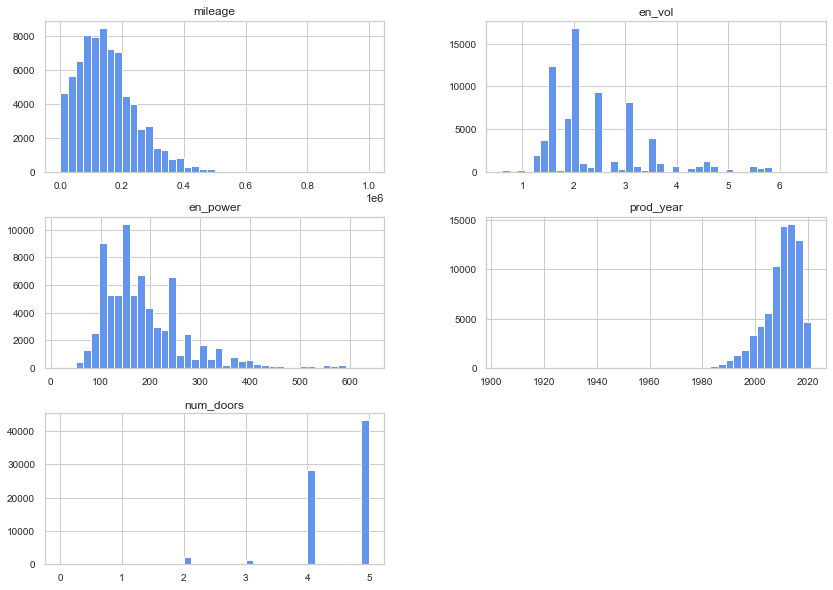

In [593]:
num_var = df.select_dtypes(include=['float64', 'int64']).drop(['price', 'train'], 1).columns.to_list()

df.loc[:, num_var].hist(sharex=False, sharey=False, bins=40, xlabelsize=10, ylabelsize=10, 
                                                    figsize=(14, 10), color='cornflowerblue')
plt.show()

* none of our numeric features has a Gaussian distribution, so we might consider power transforms like the Box-Cox transform or the Yeo-Johnson
* the distribution of variable mileage resembles lognormal or Weibull distribution
* variable en_vol has a few common values like 1,6L, 2L, 3L
* same for en_power: apparently there are some prevalent engines with certain engine displacement and power (e.g. 2.0L 150 hp)
* the vast majority of cars in the dataset were produced after 2000. However, there are also a few old-timers for sale

Further, we look at boxplots of the numeric attributes.

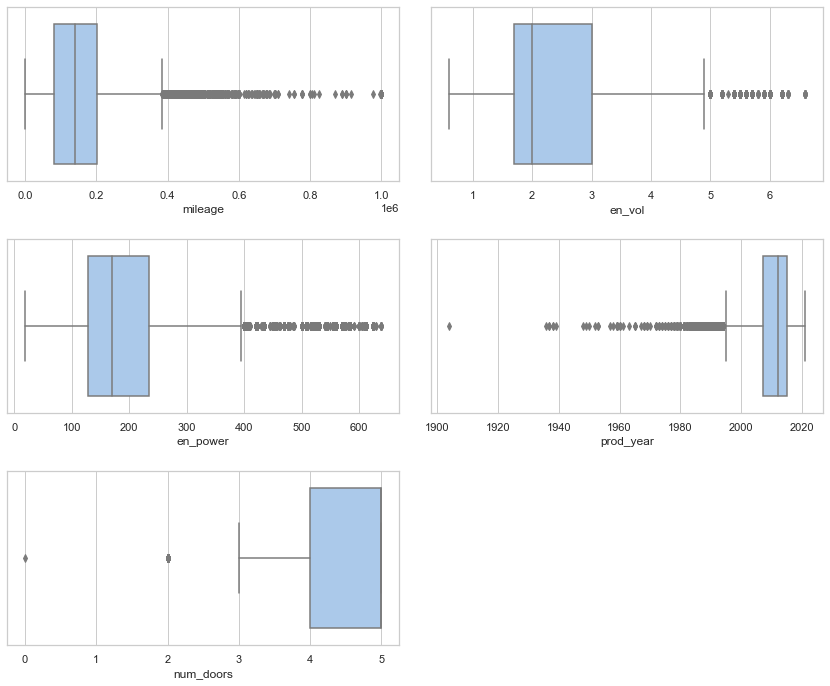

In [594]:
fig = plt.figure(figsize=(12, 10))

for index, col in enumerate(num_var):
    plt.subplot(3, 2, index+1)
    f = sns.boxplot(x=col, data=df, palette = "pastel")
fig.tight_layout(pad=2.0)

According to the plots, all variables have outliers. We might consider removing them before training a model.

Now, let's take a closer look at distribution of our output variable - price.

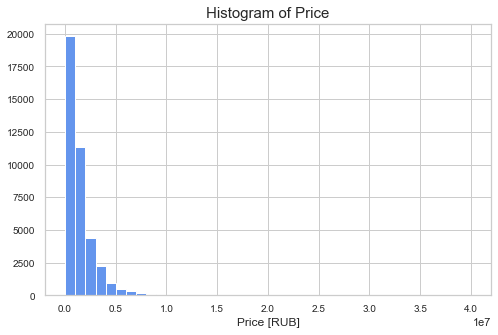

In [595]:
train['price'].hist(bins=40, xlabelsize=10, ylabelsize=10, figsize=(8, 5), color='cornflowerblue')
plt.title("Histogram of Price", fontsize=15)
plt.xlabel("Price [RUB]")
plt.show()

The distribution of price seems to be exponential.

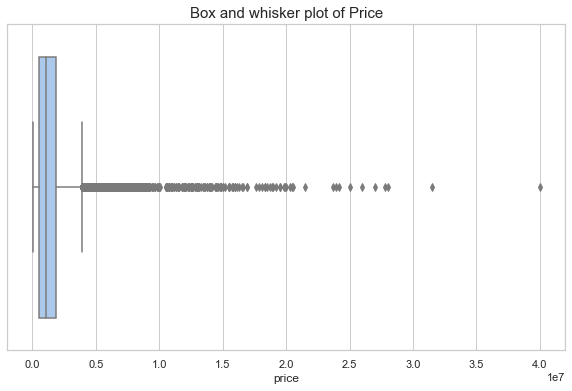

In [596]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="price", data=train, palette = "pastel")
plt.title("Box and whisker plot of Price", fontsize=15)
plt.show()

As we can see, there are quite a few values lying above 1.5 * IQR. Let's get rid of observations with prices above 10 mln RUB

In [597]:
train = train[train.price <= 10000000]
train.shape

(39849, 18)

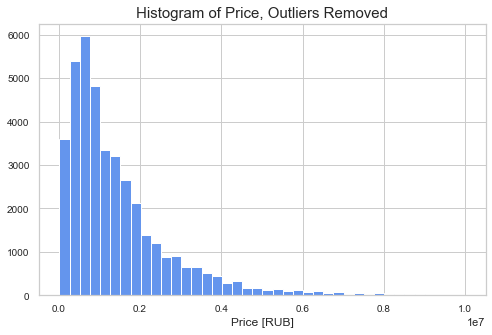

In [598]:
train['price'].hist(bins=40, xlabelsize=10, ylabelsize=10, figsize=(8, 5), color='cornflowerblue')
plt.title("Histogram of Price, Outliers Removed", fontsize=15)
plt.xlabel("Price [RUB]")
plt.show()

The distribution of our target seems log-normal to me now.

In [599]:
# train['price'] = np.log(train['price'])

Next, we check how our binary variables varies

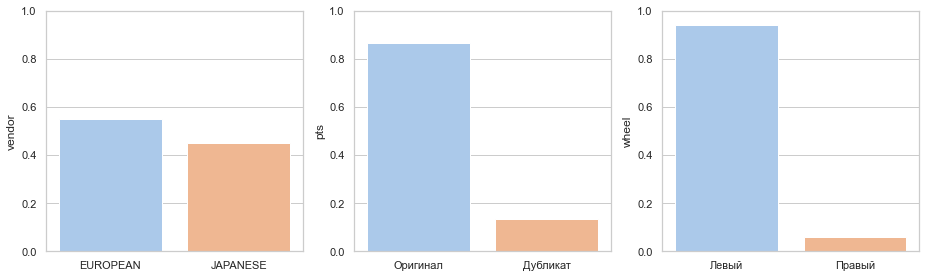

In [600]:
bin_var = ['vendor', 'pts', 'wheel']

fig = plt.figure(figsize=(13, 4))
for index, col in enumerate(bin_var):
    plt.subplot(1, 3, index+1)
    
    f = sns.barplot(x = df.loc[:, bin_var][col].value_counts(normalize=True).index, 
                y = df.loc[:, bin_var][col].value_counts(normalize=True), palette = "pastel")
    f.set(ylim=(0, 1))
    
fig.tight_layout(pad=1.0)

* there are slightly more cars produced by European manufacturers than those produced by Japanese companies
* there are much more cars with original vehicle property document (PTS) in our dataset
* the vast majority of vehicles have a wheel on the left-hand side

Let's now check our low-cardinality categorical features

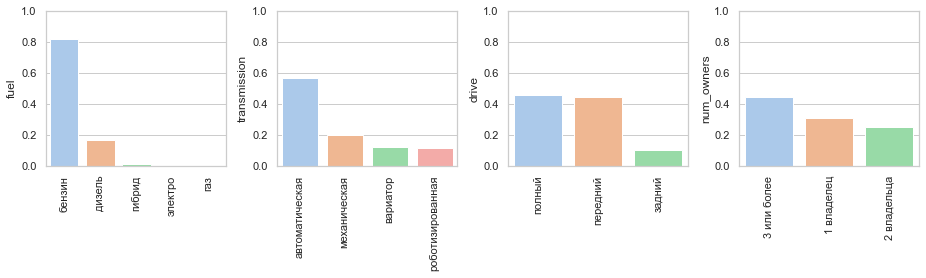

In [601]:
cat_var = ['fuel', 'transmission', 'drive', 'num_owners']

fig = plt.figure(figsize=(13, 4))
for index, col in enumerate(cat_var):
    plt.subplot(1, 4, index+1)
    plt.xticks(rotation='vertical')
    f = sns.barplot(x = df.loc[:, cat_var][col].value_counts(normalize=True).index, 
                y = df.loc[:, cat_var][col].value_counts(normalize=True), palette = "pastel")
    f.set(ylim=(0, 1))
fig.tight_layout(pad=1.0)

* petrol is by far the most popular fuel type in our data, following by diesel
* around 60 % of cars from the dataset are equipped with automatic transmission
* more than 80 % of cars from the dataset have either four-wheel drive or front-wheel drive
* only 30 & of cars have one owner

We now move to high-cardinality categorical variables

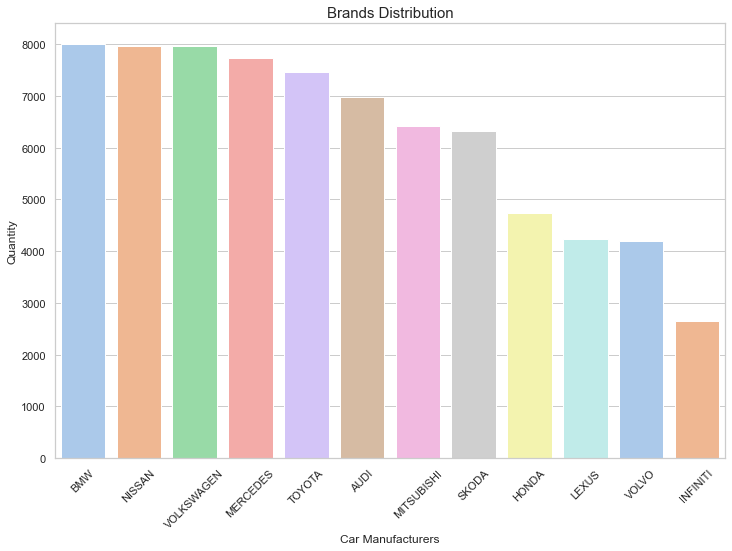

In [602]:
plt.figure(figsize=(12, 8))
sns.barplot(x=df.brand.value_counts().index, y=df.brand.value_counts().values, palette = "pastel")
plt.title("Brands Distribution", fontsize=15)
plt.xticks(rotation='45')
plt.ylabel("Quantity")
plt.xlabel("Car Manufacturers")
plt.show()

* BMW, NISSAN and VW are the most frequent car manufacturers in our dataset
* The least frequent one is INFINITI

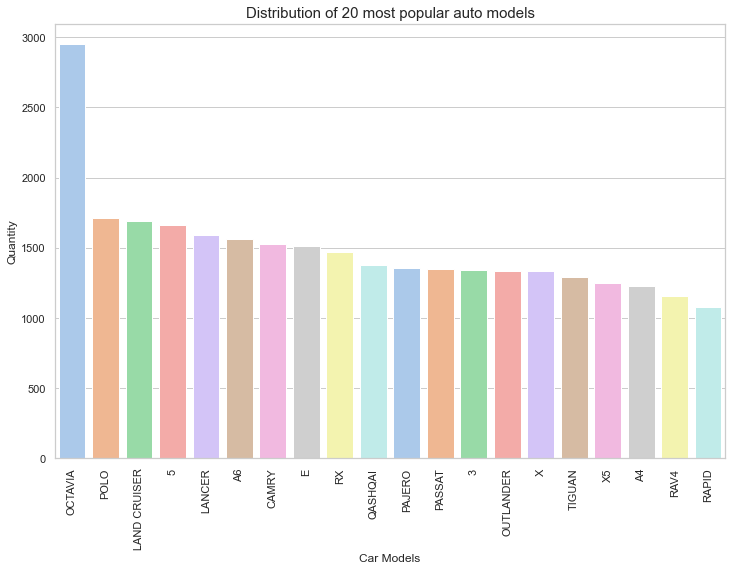

In [603]:
plt.figure(figsize=(12, 8))
sns.barplot(x=df.model_name.value_counts()[:20].index, y=df.model_name.value_counts()[:20].values, palette = "pastel")
plt.title("Distribution of 20 most popular auto models", fontsize=15)
plt.xticks(rotation='90')
plt.xlabel("Car Models")
plt.ylabel("Quantity")
plt.show()

By far the most popular car model in dataset is SKODA OCTAVIA, following by VW POLO and TOYOTA LAND CRUISER

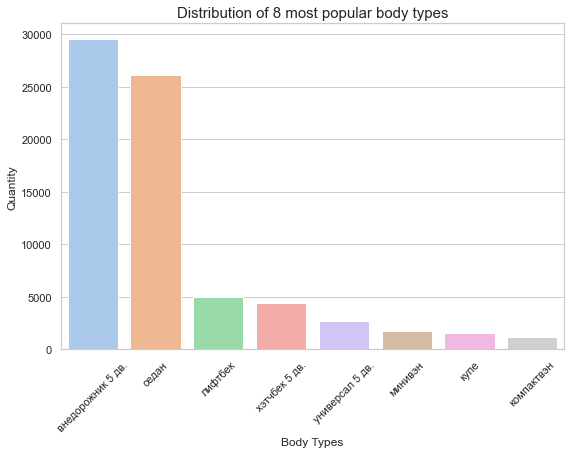

In [604]:
popular_body_types = df.body_type.value_counts()[:8].values

plt.figure(figsize=(9, 6))
plt.title("Distribution of 8 most popular body types", fontsize=15)
sns.barplot(x=df.body_type.value_counts()[:8].index, y=popular_body_types, palette = "pastel")
plt.xticks(rotation='45')
plt.xlabel("Body Types")
plt.ylabel("Quantity")
plt.show()

'внедорожник 5 дв' & 'седан' are by far the most frequent car body types

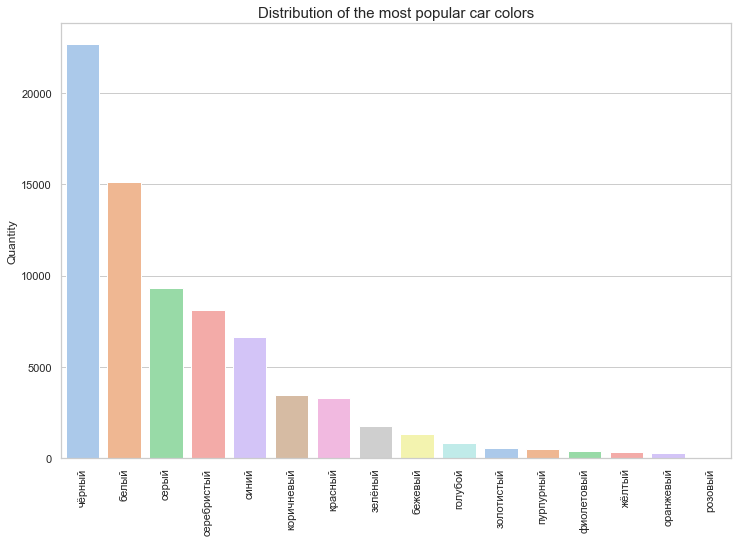

In [605]:
plt.figure(figsize=(12, 8))
sns.barplot(x=df.color.value_counts().index, y=df.color.value_counts().values, palette = "pastel")
plt.title("Distribution of the most popular car colors", fontsize=15)
plt.xticks(rotation='90')
plt.ylabel("Quantity")
plt.show()

As for car colors, the most popular one is black following by white and grey. The least frequent car color in our dataset is pink.

### 3) Multimodal data visualizations

As a next step, we conduct a miltivariate data analysis to discovere relationships between variables. 

Let's start with a scatterplot matrix to analize relationships between our numeric variables.

NB: *Note, that we are using only train set here to include our target variable into analysis*

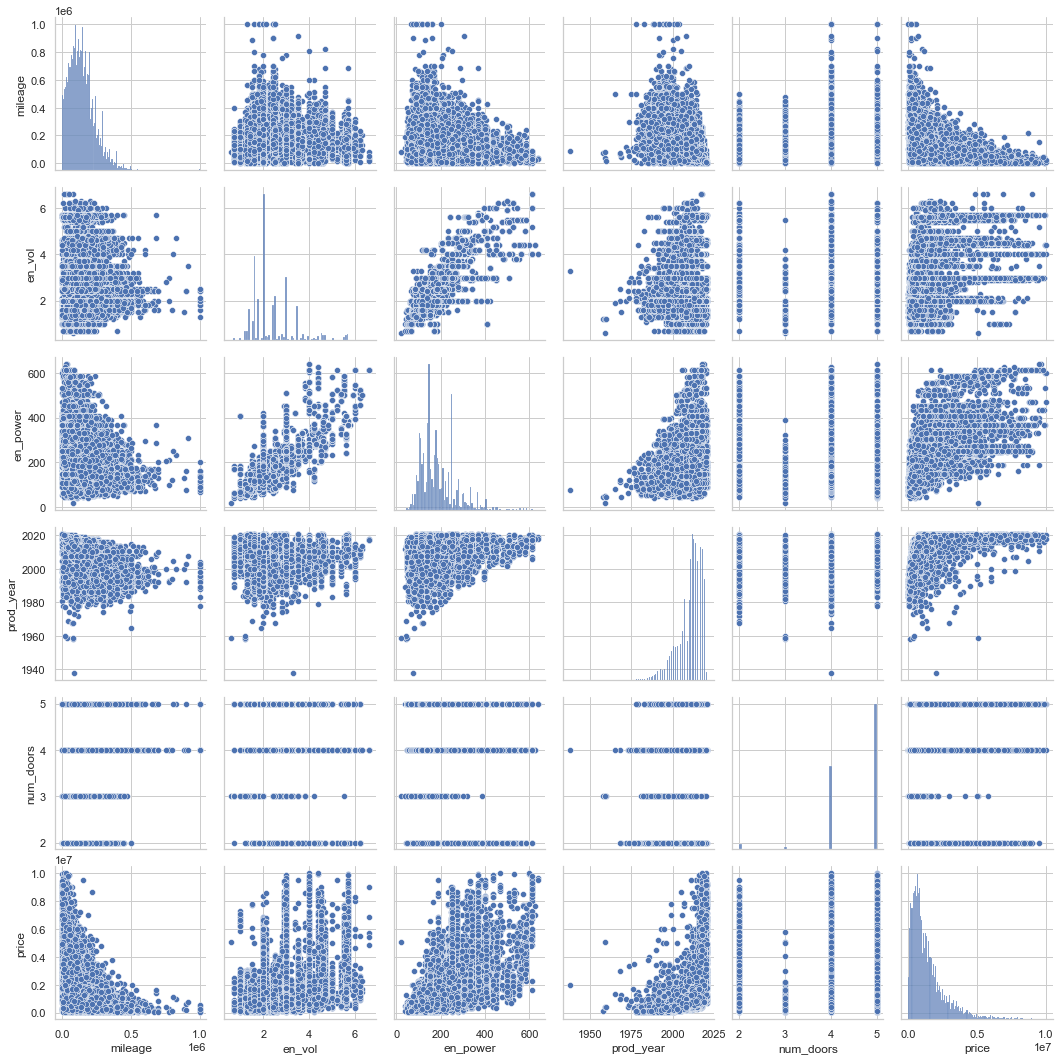

In [606]:
sns.pairplot(train.loc[:, num_var + ['price']])
plt.show()

Some insights derived from the scatterplot matrix:

* Strong positive dependancy btw engine volume and engine power
* Positive correlation btw variables 'production year' & 'engine power', as well as 'production year' & 'engine volume'
* Negative, non-linear relationship between mileage and car price
* Positive, non-linear relationship between production year and car price

Let's take a closer look at two latter relationships: mileage<->price & prod_year<->price

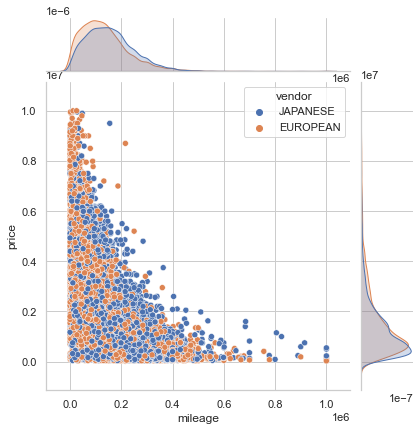

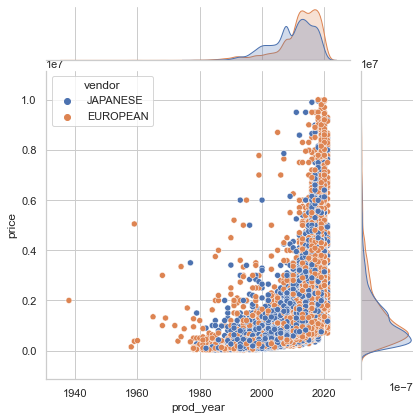

In [607]:
sns.jointplot(x=train['mileage'], y=train['price'], hue=train['vendor'])
sns.jointplot(x=train['prod_year'], y=train['price'], hue=train['vendor'])
plt.show()

* European cars tend to be slightly more expensive than the Japanese ones
* Japanese cars are older and have higher mileage (more dependable?)
* Aside from a couple outliers (probably well-safed old-timers), older cars tend to be less expensive the newer ones
* There are more old-timers from European manufacturers than from the Japanese ones

Further, we check our assumptions by means of a good old correlation matrix.

In [608]:
corr_matrix = train.loc[:, num_var+['price']].corr(method='spearman')
display(corr_matrix)

,mileage,en_vol,en_power,prod_year,num_doors,price
mileage,1.0,0.06457570065166682,-0.13789478711344474,-0.792638716646641,-0.14097891171107219,-0.6546998296165581
en_vol,0.06457570065166682,1.0,0.8386473433438829,-0.04014137620995428,0.04174046782217511,0.43342562971343446
en_power,-0.13789478711344474,0.8386473433438829,1.0,0.18435553978812108,0.04746190403059928,0.6215615137740194
prod_year,-0.792638716646641,-0.04014137620995428,0.18435553978812108,1.0,0.20614202692049735,0.7805315962107703
num_doors,-0.14097891171107219,0.04174046782217511,0.04746190403059928,0.20614202692049735,1.0,0.2256799282134293
price,-0.6546998296165581,0.43342562971343446,0.6215615137740194,0.7805315962107703,0.2256799282134293,1.0


<AxesSubplot:>

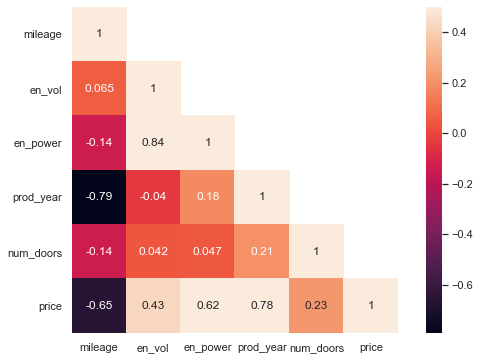

In [609]:
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
sns.heatmap(corr_matrix, mask=mask, vmax=.5, square=True, annot=True)

* Strong negative correlation btw mileage and production year (makes perfect sence)
* As already discussed, there is a negative correlation btw mileage and price
* Variables 'en_power' & 'prod_year' seem to have a strong positive impact on our target - price
* As already mentioned, engine volume & engine power are positively correlated. We might consider removing one of these features to avoid multicollinearity.

Further, we investigate relationships btw our categorical variables and the trarget.
Let's start with binomial variables.

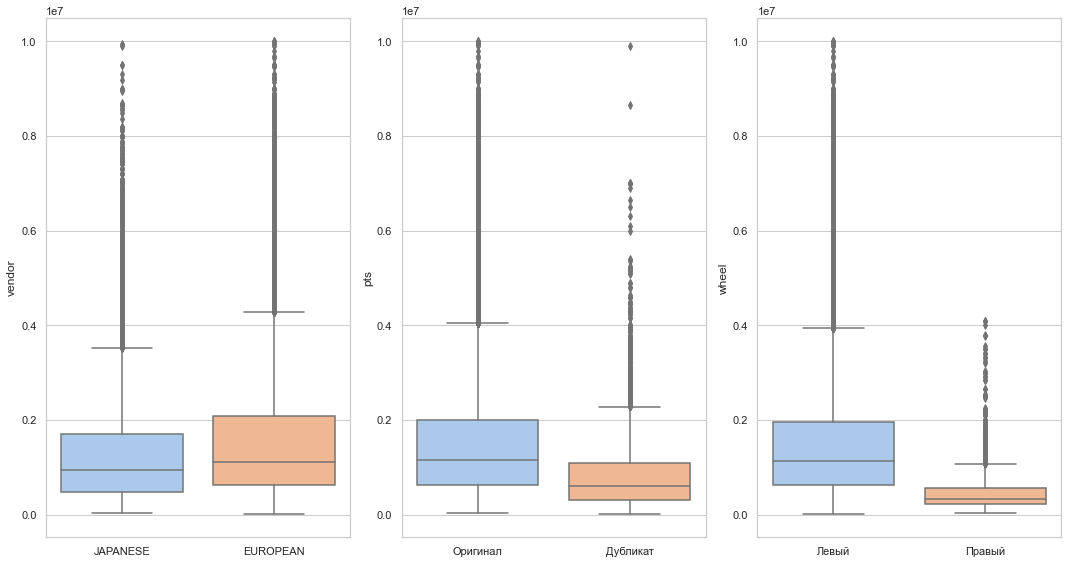

In [610]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))

for idx, feat in enumerate(bin_var):
    ax = axes[idx]
    sns.boxplot(x=feat, y='price', data=train, ax=ax, palette = "pastel")
    ax.set_xlabel("")
    ax.set_ylabel(feat)
fig.tight_layout()
plt.show()

* vehicles produced by European vendors tend to be more expensive than those of Japanese manufacturers
* cars with original vehicle property document (PTS) have higher value
* cars with a wheel on the left-hand side tend to be more expensive

Moving on to our low-cardinality categorical variables:

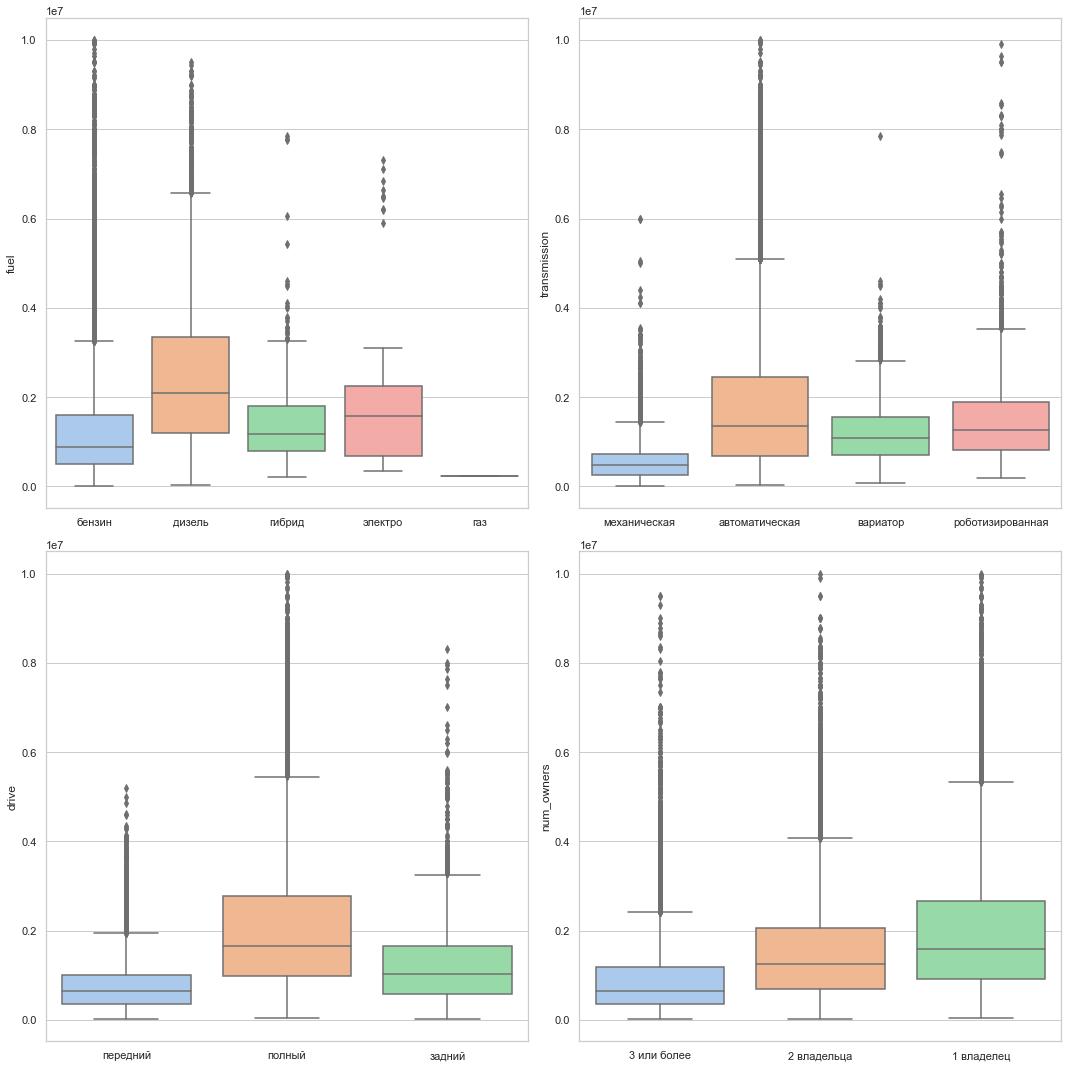

In [611]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

for idx, feat in enumerate(cat_var):
    ax = axes[int(idx / 2), idx % 2]
    sns.boxplot(x=feat, y='price', data=train, ax=ax, palette = "pastel")
    ax.set_xlabel("")
    ax.set_ylabel(feat)
fig.tight_layout()
plt.show()

* fuel: diesel & e-powered cars tend to be more expensive
* transmission: cars equipped with manual transmission have lower value
* drive: cars with full-wheel drive are more expensive, following by RWD vehicles
* owner: more owners -> less expensive

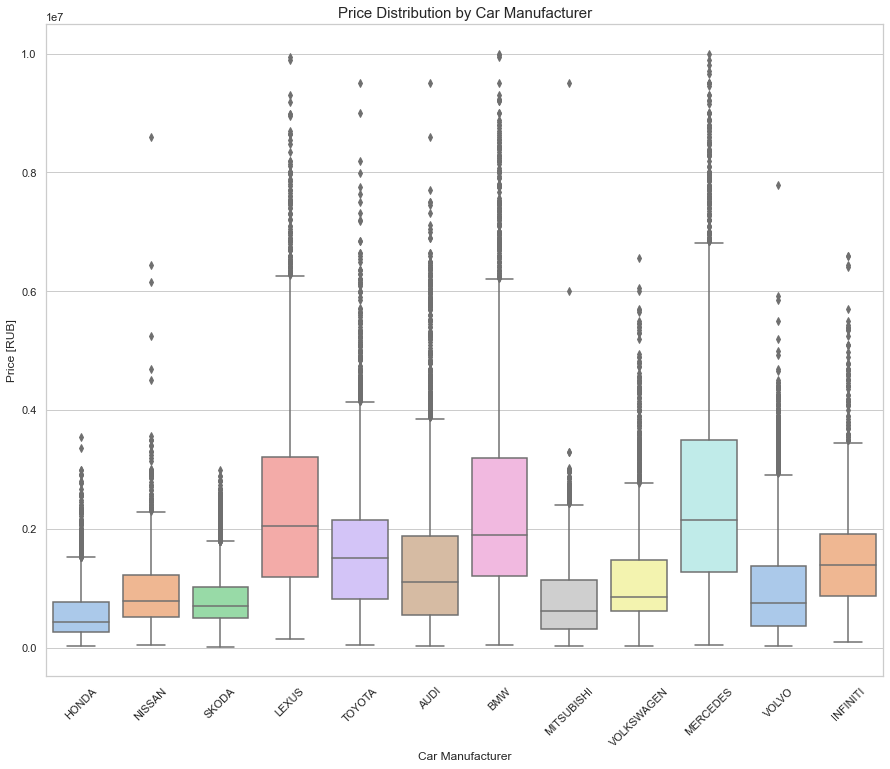

In [612]:
plt.figure(figsize=(15, 12))
sns.boxplot(x="brand", y="price", data=train, palette = "pastel")
plt.title("Price Distribution by Car Manufacturer", fontsize=15)
plt.xticks(rotation='45')
plt.xlabel('Car Manufacturer')
plt.ylabel('Price [RUB]')
plt.show()

Among car manufacturers, LEXUS, MERCEDES and BMW tend to have higher prices; HONDA, SKODA & MITSUBISHI - lower prices.

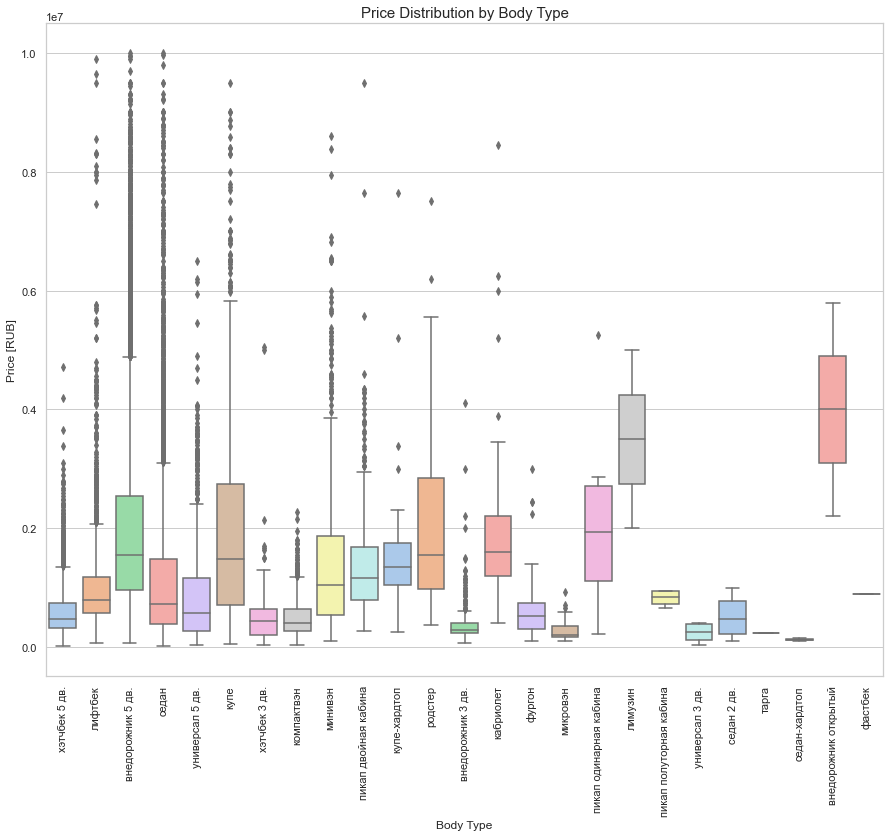

In [613]:
plt.figure(figsize=(15, 12))
sns.boxplot(x='body_type', y="price", data=train, palette = "pastel")
plt.title("Price Distribution by Body Type", fontsize=15)
plt.xticks(rotation='90')
plt.xlabel('Body Type')
plt.ylabel('Price [RUB]')
plt.show()

* лимузин & открытый внедорожник tend to have the highest prices among all body types
* универсал 3 дв., внедорожник 3 дв., микровэн, хэтчбэк 5 дв и 3 дв, компактвэн are car body types with lowest market values
* внедорожник 5 дв. and купе are body types with the largest price variance

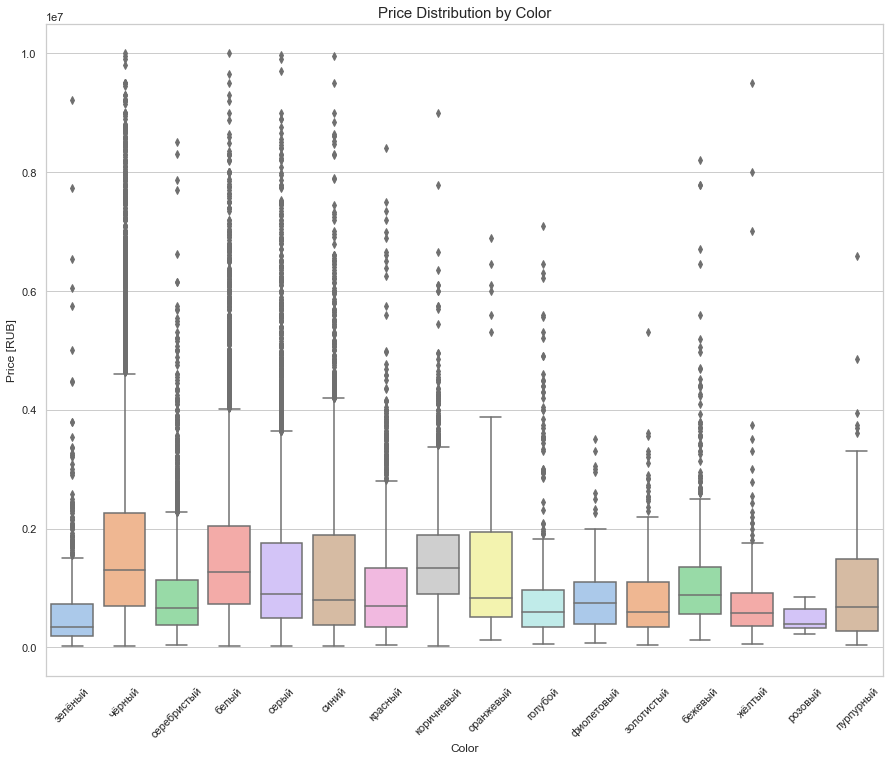

In [614]:
plt.figure(figsize=(15, 12))
sns.boxplot(x="color", y="price", data=train, palette = "pastel")
plt.title("Price Distribution by Color", fontsize=15)
plt.xticks(rotation='45')
plt.xlabel('Color')
plt.ylabel('Price [RUB]')
plt.show()

The most popular colors - black & white - also tend to be the most expensive ones in terms of car prices. It seems like green cars have lower market value on average.

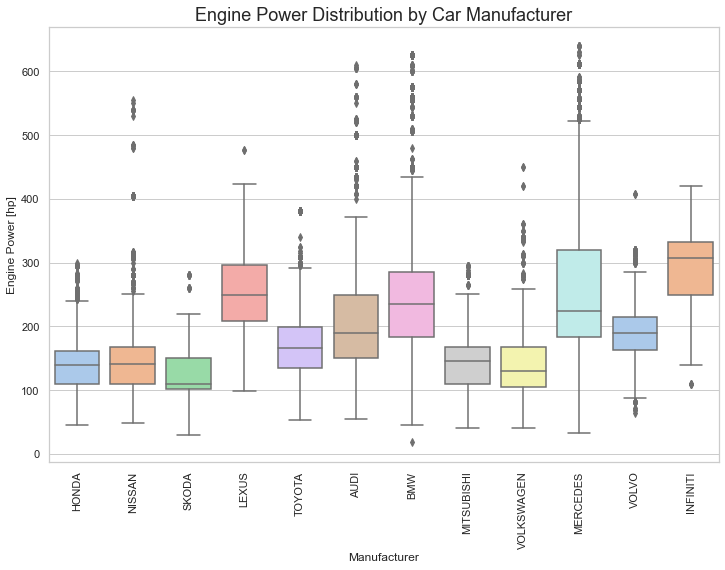

In [615]:
plt.figure(figsize=(12, 8))
plt.xticks(rotation='90')
ax = sns.boxplot(x="brand", y="en_power", data=df, palette = "pastel")
ax.set(xlabel='Manufacturer', ylabel='Engine Power [hp]')
ax.set_title('Engine Power Distribution by Car Manufacturer', fontsize=18)
plt.show()

* The most expensive car brands - LEXUS, BMW, INFINITI, MERCEDES - also tend to have the most powerful engines, which reflects high importance of the variable en_power for our target;
* IFINITI has the highest median engine power, yet not the highest median price;
* SKODA is a car manufacturer with the lowest median engine power.

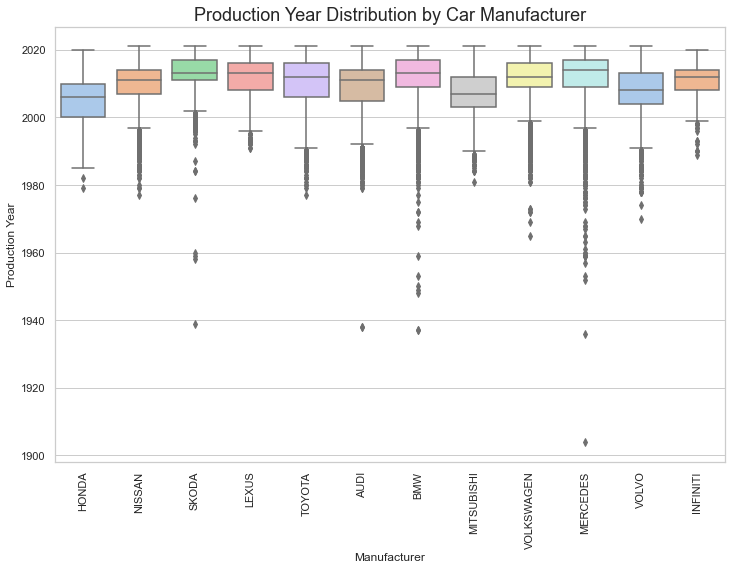

In [616]:
plt.figure(figsize=(12, 8))
plt.xticks(rotation='90')
ax = sns.boxplot(x="brand", y="prod_year", data=df, palette = "pastel")
ax.set(xlabel='Manufacturer', ylabel='Production Year')
ax.set_title('Production Year Distribution by Car Manufacturer', fontsize=18)
plt.show()

There is no much variance in production year distribution by car manufacturer. On average, HONDA vehicles tend to be the oldest ones in our dataset.

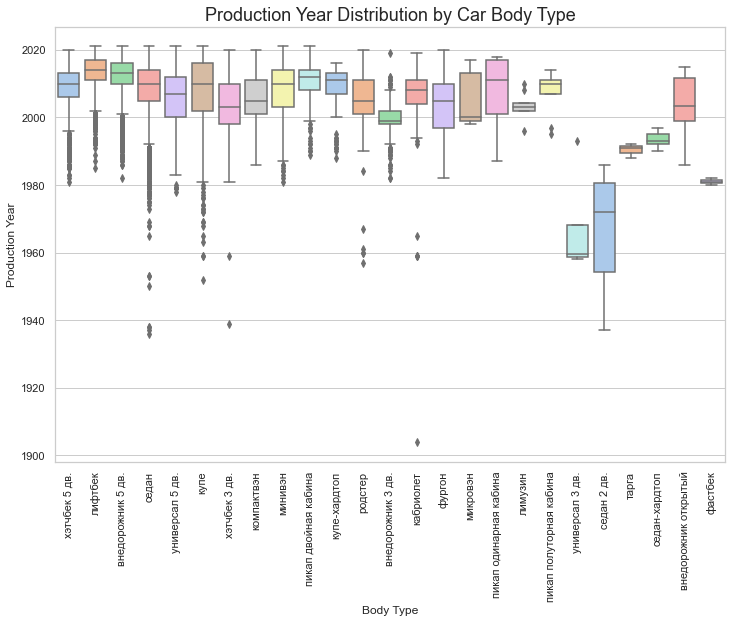

In [617]:
plt.figure(figsize=(12, 8))
plt.xticks(rotation='90')
ax = sns.boxplot(x="body_type", y="prod_year", data=df, palette = "pastel")
ax.set(xlabel='Body Type', ylabel='Production Year')
ax.set_title('Production Year Distribution by Car Body Type', fontsize=18)
plt.show()

Among car body types, седан 2 дв & универсал 3 дв seem to be the outdated ones.

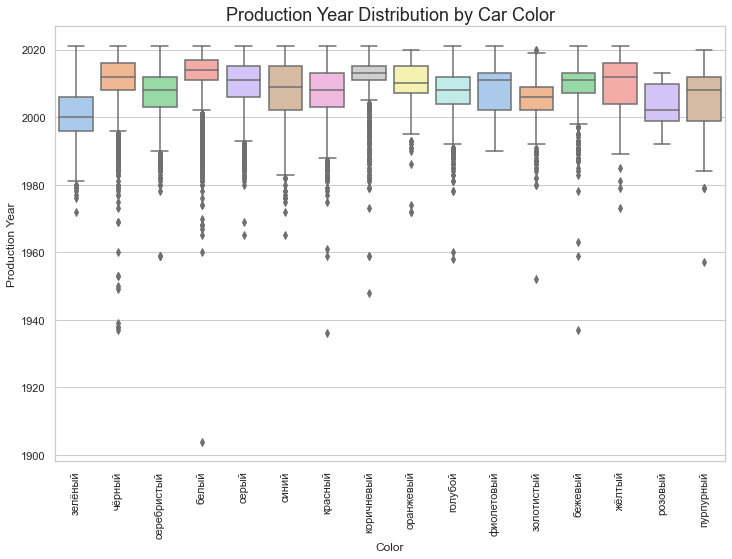

In [618]:
plt.figure(figsize=(12, 8))
plt.xticks(rotation='90')
ax = sns.boxplot(x="color", y="prod_year", data=df, palette = "pastel")
ax.set(xlabel='Color', ylabel='Production Year')
ax.set_title('Production Year Distribution by Car Color', fontsize=18)
plt.show()

There are no obvious dependancies between car production year and car colors. Green seems to be outdated. Remember also that green cars have lower market value on average.

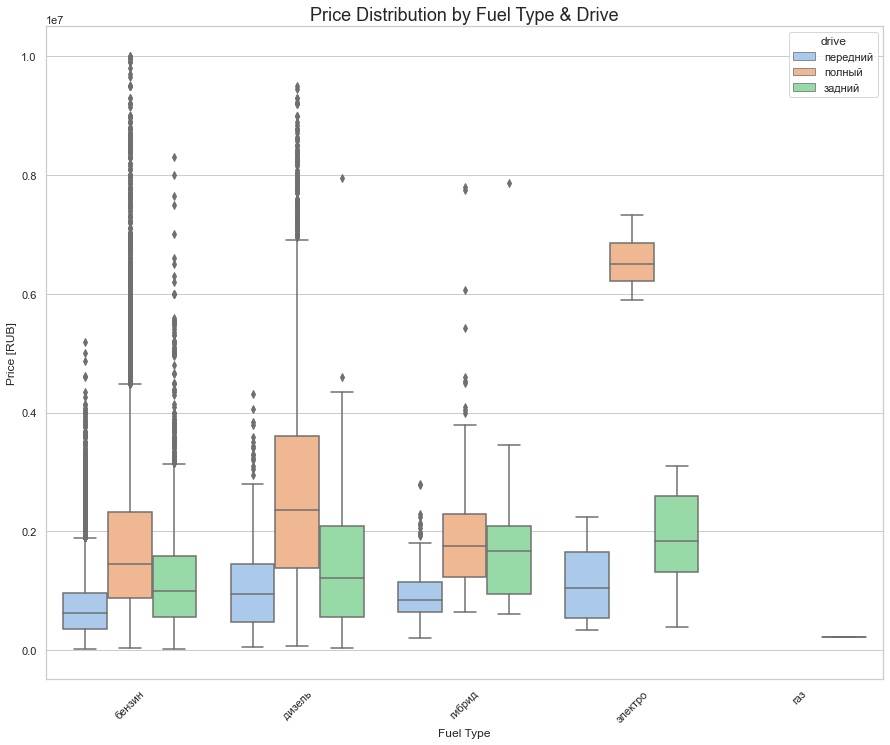

In [619]:
plt.figure(figsize=(15, 12))
plt.xticks(rotation='45')
ax = sns.boxplot(x="fuel", y="price", hue='drive', data=train, palette = "pastel")
ax.set(xlabel='Fuel Type', ylabel='Price [RUB]')
ax.set_title('Price Distribution by Fuel Type & Drive', fontsize=18)
plt.show()

Among all fuel types, full-wheel drive cars tend to have higher market value. The most drastic difference is observed by Diesel fueled vehicles and by e-cars. Let's investigate why 4WD e-powered vehicles are so much more expensive than the other ones:

In [620]:
df[(df.drive=='полный') & (df.fuel=='электро')]['model_name'].value_counts()

EQC    5
E      5
Name: model_name, dtype: int64

There are only 10 4WD e-cars in our dataset, of which all are high-end, newly introduced electric SUVs: MERCEDES EQC & AUDI E-Tron.

Let's now take a closer look at 20 most expensive car models from our dataset:

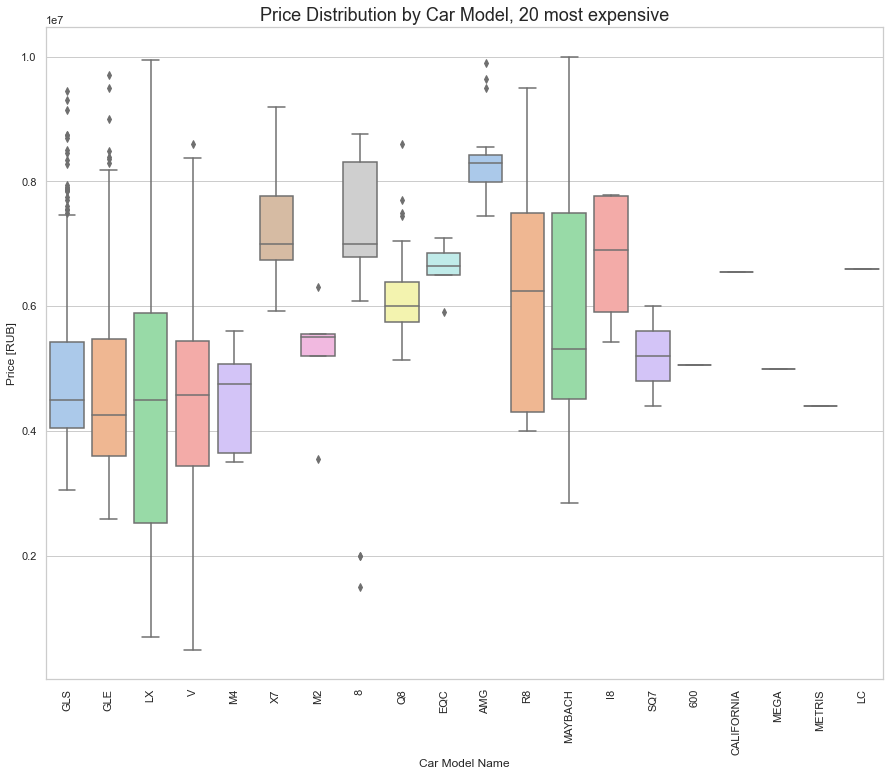

In [621]:
# 20 most expensive models: boxplot
most_expensive_models = train.groupby('model_name')['price'].median().sort_values(ascending=False)[:20].index.to_list()
data = train[train['model_name'].isin(most_expensive_models)]

plt.figure(figsize=(15, 12))
plt.xticks(rotation='90')
ax = sns.boxplot(x="model_name", y="price", data=data, palette = "pastel")
ax.set(xlabel='Car Model Name', ylabel='Price [RUB]')
ax.set_title('Price Distribution by Car Model, 20 most expensive', fontsize=18)
plt.show()

As we can see, the most expensive car models are produced by European manufacturers BMW & Mercedes. These are 
* MERCEDES: AMG models, EQC
* BMW: 8 series, X7, I8

It is also noteworthy that LEXUS LX has the largest price variance. Cars of this model are sold at prices between 700.000 RUB and 9.950.000 RUB!

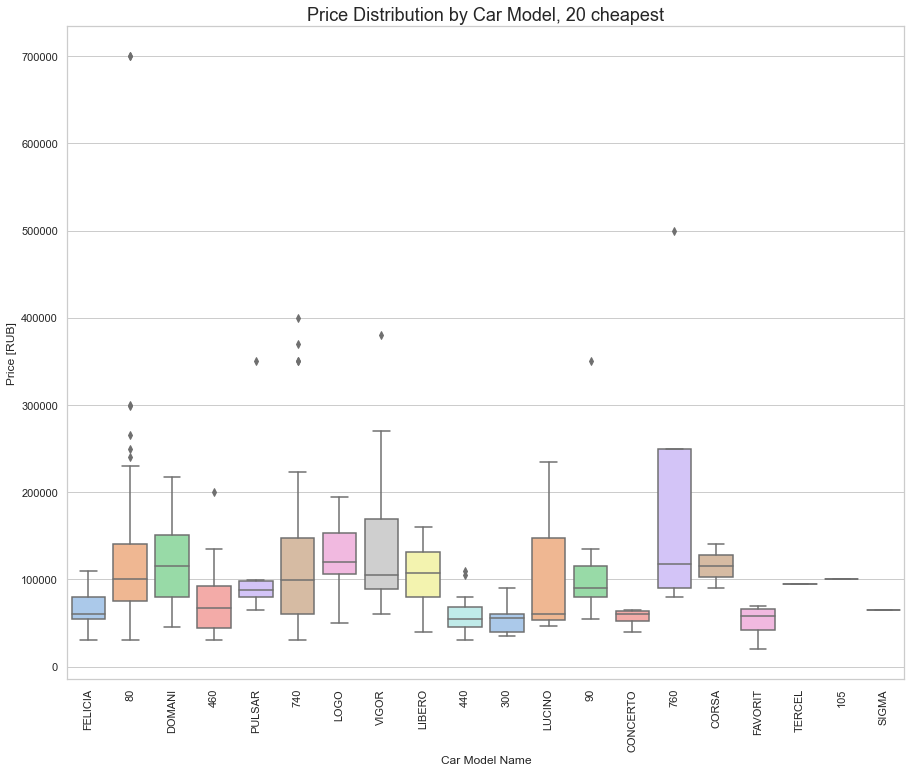

In [622]:
# 20 cheapest models: boxplot
cheapest_models = train.groupby('model_name')['price'].median().sort_values(ascending=True)[:20].index.to_list()
data = train[train['model_name'].isin(cheapest_models)]

plt.figure(figsize=(15, 12))
plt.xticks(rotation='90')
ax = sns.boxplot(x="model_name", y="price", data=data, palette = "pastel")
ax.set(xlabel='Car Model Name', ylabel='Price [RUB]')
ax.set_title('Price Distribution by Car Model, 20 cheapest', fontsize=18)
plt.show()

Among 20 car models with the lowest market value, VOLVO 440 & 300, SKODA FELICIA & FAVORIT as well as HONDA CONCERTO are the cheapest car models.

Further, we examine how the price varies by production year.

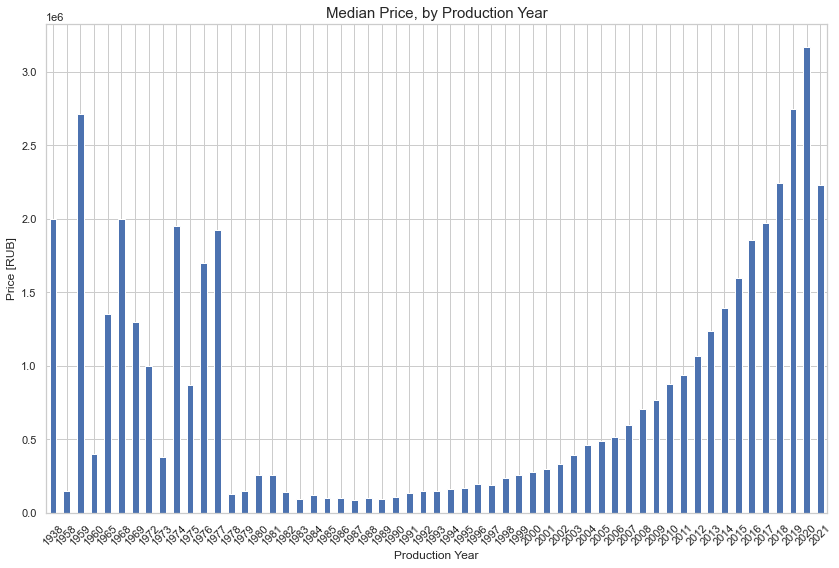

In [623]:
# median price by prodaction year
plt.figure(figsize=(14, 9))
train.groupby('prod_year')['price'].median().plot(kind='bar')
plt.title("Median Price, by Production Year", fontsize=15)
plt.xticks(rotation='45')
plt.xlabel('Production Year')
plt.ylabel('Price [RUB]')
plt.show()

Starting from 1978 there is a straightforward growing price trend: newer cars tend to have higher market value. However, in years prior to 1978 we observe much higher median price variety. Let's try to find a reason behind it.

In [624]:
# create new dataset with cars produced prior to 1978
oldtimers = train[train.prod_year < 1978]
oldtimers.shape

(17, 18)

Unfortunately, there are only 17 observations with such conditions in our train dataset. Clearly not enough to conduct any feasibly analysis. I would like to check one assumption though:

My hypothesis is that there are restored, collectible classic models in our dataset, which are more expensive. In that case, I would expect lower mileage values for such cars. Let's check the assumption using correlation matrix.

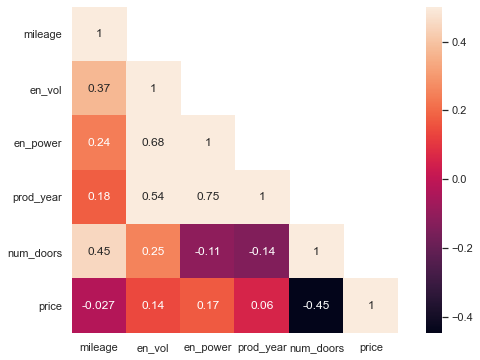

In [625]:
corr_matrix = oldtimers.loc[:, num_var+['price']].corr(method='spearman')

mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
sns.heatmap(corr_matrix, mask=mask, vmax=.5, square=True, annot=True)
plt.show()

There is no correlation btw mileage and price, which means that the assumption was not confirmed. I also don't see any new, useful insights.

#### The most relevant findings of EDA:

- among numeric numeric variables, production year, mileage and engine power have the biggest influence on the targer
- among categorical variables: drive, fuel type, num of owners
- the variables brand, model name and body type also seem to be important

The findings will definitely come in handy for feature engineering. But firstly let's train a simple baseline model, which score we will then try to improve.

### 4) Baseline Model

We use CatBoost Regressor as a baseline model to save some time and effort turning our categorical variables to numbers.

In [626]:
X = train.copy().drop('train', 1)
y = X.pop('price')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=29)

In [627]:
cat_features = ['brand', 'model_name', 'body_type', 'color', 'fuel', 'transmission',
               'drive', 'vendor', 'num_owners', 'pts', 'wheel']

In [628]:
model = CatBoostRegressor(iterations=200, random_state=29)

model.fit(X_train, y_train, cat_features=cat_features, plot=True)
y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.242801
0:	learn: 1102532.4651475	total: 57.1ms	remaining: 11.4s
1:	learn: 920211.9920774	total: 125ms	remaining: 12.4s
2:	learn: 780000.5815690	total: 186ms	remaining: 12.2s
3:	learn: 674317.6438341	total: 246ms	remaining: 12.1s
4:	learn: 594310.1062963	total: 308ms	remaining: 12s
5:	learn: 535990.0889168	total: 363ms	remaining: 11.7s
6:	learn: 495123.5551997	total: 422ms	remaining: 11.6s
7:	learn: 463633.4942384	total: 481ms	remaining: 11.5s
8:	learn: 442360.4404536	total: 536ms	remaining: 11.4s
9:	learn: 425728.0785993	total: 596ms	remaining: 11.3s
10:	learn: 410642.9371452	total: 657ms	remaining: 11.3s
11:	learn: 399798.4829837	total: 716ms	remaining: 11.2s
12:	learn: 389137.2894512	total: 799ms	remaining: 11.5s
13:	learn: 383233.6119219	total: 861ms	remaining: 11.4s
14:	learn: 376915.4928787	total: 925ms	remaining: 11.4s
15:	learn: 372834.6017071	total: 981ms	remaining: 11.3s
16:	learn: 369787.2277651	total: 1.04s	remaining: 11.2s
17:	learn: 367024.8953113	to

146:	learn: 256348.5354232	total: 9s	remaining: 3.24s
147:	learn: 256100.6364705	total: 9.07s	remaining: 3.19s
148:	learn: 255851.0955464	total: 9.13s	remaining: 3.13s
149:	learn: 255404.9321847	total: 9.19s	remaining: 3.06s
150:	learn: 255288.4088555	total: 9.25s	remaining: 3s
151:	learn: 254923.9407799	total: 9.31s	remaining: 2.94s
152:	learn: 254660.9699978	total: 9.37s	remaining: 2.88s
153:	learn: 254195.6161030	total: 9.43s	remaining: 2.82s
154:	learn: 253964.3368278	total: 9.48s	remaining: 2.75s
155:	learn: 253961.4014230	total: 9.54s	remaining: 2.69s
156:	learn: 253737.3086647	total: 9.6s	remaining: 2.63s
157:	learn: 253643.4799198	total: 9.68s	remaining: 2.57s
158:	learn: 253616.2239860	total: 9.75s	remaining: 2.51s
159:	learn: 253347.0617533	total: 9.81s	remaining: 2.45s
160:	learn: 252835.9910997	total: 9.87s	remaining: 2.39s
161:	learn: 252705.7002419	total: 9.94s	remaining: 2.33s
162:	learn: 252411.0428793	total: 10s	remaining: 2.27s
163:	learn: 251922.6749863	total: 10.1s	

0.15197375305748187

So we've achieved a MAPE of 15,4% which is not bad at all, especially considering the fact that we havn't conducted any feature engineering or parameter tuning so far. Let's now try to improve the score!

## FEATURE ENGINEERING <a name="featureeng"></a>

We can now proceed to one of the most important steps on the way to building a great machine learning model: **feature engineering**. The goal of feature engineering is simply to make our data better suited to the problem at hand. Our plan for this project section is as follows:
* invent new features using our findings from *exploratory data analysis*
* encode high-cardinality categoricals with a *target encoding*
* create segmentation features with *k-means clustering*
* determine which features are the most important with *mutual information*
* standardize data

### 1) Inventing new features

In [629]:
df = pd.concat([train, test], ignore_index=False)

In [630]:
# how many hp from one liter engine volume
df['power_vol'] = round(df['en_power'] / df['en_vol'], 3) 

In [631]:
# old-timers: label cars produced prior to 1978
df['oldtimer'] = [1 if x < 1978 else 0 for x in df['prod_year']]

In [632]:
# luxury brands
df['luxury'] = [1 if x in ['LEXUS', 'MERCEDES', 'BMW'] else 0 for x in df['brand']]

In [633]:
# affordable brands
df['luxury'] = [1 if x in ['HONDA', 'SKODA', 'MITSUBISHI'] else 0 for x in df['brand']]

In [634]:
# popular color
df['pop_color'] = [1 if x in ['черный', 'белый', 'серый'] else 0 for x in df['color']]

In [635]:
# combine brand name & car body type
df['brand_body'] = df['brand'] + '_' + df['body_type']

In [636]:
# combine brand name & production year
df['brand_year'] = df['brand'] + '_' + [str(x) for x in df['prod_year']]

In [637]:
# combine brand name & drive type
df['brand_drive'] = df['brand'] + '_' + df['drive']

In [638]:
# combine brand name & fuel type
df['brand_fuel'] = df['brand'] + '_' + df['fuel']

In [639]:
# combine fuel type & drive type
df['fuel_drive'] = df['fuel'] + '_' + df['drive']

In [640]:
# median mileage for each model 
df['medianmileage_model'] = round(df.groupby('model_name')['mileage'].transform('median'), 3)

In [641]:
# miles per year
df['miles_per_year'] = round(df['mileage'] / (2022 - df['prod_year']), 3)

In [642]:
# median mileage for each body type 
df['medianmileage_body_type'] = round(df.groupby('body_type')['mileage'].transform('median'), 3)

In [643]:
# median engine power for each brand
df['medianpower_brand'] = round(df.groupby('brand')['en_power'].transform('median'), 3)

In [644]:
# median engine power for each model
df['medianpower_model'] = round(df.groupby('model_name')['en_power'].transform('median'), 3)

In [645]:
# median engine power for each body type
df['medianpower_body_type'] = round(df.groupby('body_type')['en_power'].transform('median'), 3)

In [646]:
# median engine power for each fuel type
df['medianpower_fuel'] = round(df.groupby('fuel')['en_power'].transform('median'), 3)

In [647]:
# median engine power for each drive type
df['medianpower_drive'] = round(df.groupby('drive')['en_power'].transform('median'), 3)

In [648]:
# remove en_power & en_vol to avoid multicollinearity
df.drop(['en_power', 'en_vol'], 1, inplace=True) 

In [649]:
df.head().T

,0,1,2,3,4
brand,HONDA,NISSAN,SKODA,LEXUS,TOYOTA
model_name,JAZZ,NOTE,OCTAVIA,RX,CAMRY
body_type,хэтчбек 5 дв.,хэтчбек 5 дв.,лифтбек,внедорожник 5 дв.,седан
mileage,"294,000.0","96,000.0","360,000.0","67,000.0","30,406.0"
color,зелёный,чёрный,серебристый,белый,чёрный
fuel,бензин,бензин,бензин,бензин,бензин
transmission,механическая,механическая,механическая,автоматическая,автоматическая
drive,передний,передний,передний,передний,передний
prod_year,2002,2012,2008,2016,2018
num_doors,5,5,5,5,4


In [650]:
df_1 = df.copy()

In [651]:
df.reset_index(inplace=True)

### 2) Robust scaling data

Next, we standardize our numeric variables since our they aren't naturally on the same scale. Some of our input variables have outliers. Thus, we will use robust data scaling [VALUE = (VALUE - MEDIAN) / (p75 - p25)]. The resulting variable has a zero mean and median and a standard deviation of 1, although not skewed by outliers and the outliers are still present with the same relative relationships to other values.

In [652]:
X = df.drop(['train', 'price'], 1)
col_names = X.select_dtypes(['float64', 'int64']).columns.to_list()

In [653]:
trans = RobustScaler()
X_scaled = pd.DataFrame(trans.fit_transform(X.loc[:, col_names]), columns=col_names)

In [654]:
X_scaled.describe()

,index,mileage,prod_year,num_doors,power_vol,oldtimer,luxury,pop_color,medianmileage_model,miles_per_year,medianmileage_body_type,medianpower_brand,medianpower_model,medianpower_body_type,medianpower_fuel,medianpower_drive
count,"74,535.0","74,535.0","74,535.0","74,535.0","74,535.0","74,535.0","74,535.0","74,535.0","74,535.0","74,535.0","74,535.0","74,535.0","74,535.0","74,535.0","74,535.0","74,535.0"
mean,0.005005853566674654,0.10517348100913898,-0.2406889380827799,-0.4963171664318776,0.1922430144921144,0.0007647413966592875,0.23449386194405314,0.3272556517072516,0.058069353775093834,0.08410562674037662,-0.004588207615819125,0.1427446996776842,0.1490577981955557,0.1367762480319155,5.4666532501509355,-0.07293204534782315
std,0.5859976770117701,0.8075102748486537,0.8832894405414282,0.6759651660874387,0.9161247126510333,0.027643567420137388,0.4236849053702342,0.46921460329412656,0.8933062053381879,0.8995227771746092,0.6490999300711738,0.5882705303009469,0.8352597047530078,0.9512449264843129,12.90518878743647,0.47516284344012716
min,-1.0001071179904666,-1.1508580118785836,-13.5,-5.0,-3.4227714909668463,0.0,0.0,0.0,-2.428366998256767,-1.8450809046441397,-2.083818536178767,-0.6666666666666666,-1.735632183908046,-3.6029411764705883,-47.0,-0.59
25%,-0.5,-0.4767874391171212,-0.625,-1.0,-0.34742902521342073,0.0,0.0,0.0,-0.4792589958630738,-0.4743255363206043,-0.5638567803777841,-0.30952380952380953,-0.4482758620689655,0.0,0.0,-0.59
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.5,0.5232125608828788,0.375,0.0,0.6525709747865792,0.0,0.0,1.0,0.5207410041369261,0.5256744636793956,0.43614321962221597,0.6904761904761905,0.5517241379310345,1.0,0.0,0.41
max,1.1420384553585774,7.0696068558745555,1.125,0.0,16.5276950565813,1.0,1.0,1.0,6.244416884209431,12.706143886949603,3.983770730929996,1.6785714285714286,5.241379310344827,8.147058823529411,34.0,0.41


We can see that the distributions have been adjusted. The median values are now zero and the standard deviation values are now close to 1.0.

In [655]:
X_scaled.head()

,index,mileage,prod_year,num_doors,power_vol,oldtimer,luxury,pop_color,medianmileage_model,miles_per_year,medianmileage_body_type,medianpower_brand,medianpower_model,medianpower_body_type,medianpower_fuel,medianpower_drive
0,-1.0001071179904666,1.2659528555868391,-1.25,0.0,-0.5536033353186424,0.0,1.0,0.0,0.4927712201764048,0.30426450948242245,0.0,-0.30952380952380953,-1.0,-1.911764705882353,0.0,-0.59
1,-1.0000535589952333,-0.361700815881954,0.0,0.0,-0.6026900933095097,0.0,0.0,0.0,-0.005906177636314753,-0.44142736537118066,0.0,-0.2976190476190476,-0.6954022988505747,-1.911764705882353,0.0,-0.59
2,-1.0,1.80850407940977,-0.5,0.0,0.4135894381576335,0.0,1.0,0.0,0.06938240982454923,1.9147083482106173,-0.5442443706255133,-0.6666666666666666,-0.5517241379310345,-1.411764705882353,0.0,-0.59
3,-0.9999464410047667,-0.6000945354405146,0.5,0.0,2.1838395870557874,0.0,0.0,1.0,-0.310382210350121,-0.21235857076308862,-0.5638567803777841,0.9880952380952381,0.7816091954022989,1.0,0.0,-0.59
4,-0.9998928820095335,-0.9009145276310652,0.75,-1.0,-0.1290450665078417,0.0,0.0,0.0,-0.4792589958630738,-0.7336362304486171,0.43614321962221597,0.0,0.12643678160919541,0.0,0.0,-0.59


In [656]:
X_scaled = pd.concat([df.select_dtypes(["category", "object"]).reset_index(), X_scaled], axis=1)

In [657]:
X_scaled.drop('index', 1, inplace=True)
X_scaled['train'] = df['train']
X_scaled['price'] = df['price']

In [658]:
X_scaled.head()

,brand,model_name,body_type,color,fuel,transmission,drive,vendor,num_owners,pts,...,medianmileage_model,miles_per_year,medianmileage_body_type,medianpower_brand,medianpower_model,medianpower_body_type,medianpower_fuel,medianpower_drive,train,price
0,HONDA,JAZZ,хэтчбек 5 дв.,зелёный,бензин,механическая,передний,JAPANESE,3 или более,Оригинал,...,0.4927712201764048,0.30426450948242245,0.0,-0.30952380952380953,-1.0,-1.911764705882353,0.0,-0.59,1,"295,000.0"
1,NISSAN,NOTE,хэтчбек 5 дв.,чёрный,бензин,механическая,передний,JAPANESE,3 или более,Оригинал,...,-0.005906177636314753,-0.44142736537118066,0.0,-0.2976190476190476,-0.6954022988505747,-1.911764705882353,0.0,-0.59,1,"515,000.0"
2,SKODA,OCTAVIA,лифтбек,серебристый,бензин,механическая,передний,EUROPEAN,2 владельца,Оригинал,...,0.06938240982454923,1.9147083482106173,-0.5442443706255133,-0.6666666666666666,-0.5517241379310345,-1.411764705882353,0.0,-0.59,1,"330,000.0"
3,LEXUS,RX,внедорожник 5 дв.,белый,бензин,автоматическая,передний,JAPANESE,1 владелец,Оригинал,...,-0.310382210350121,-0.21235857076308862,-0.5638567803777841,0.9880952380952381,0.7816091954022989,1.0,0.0,-0.59,1,"2,900,000.0"
4,TOYOTA,CAMRY,седан,чёрный,бензин,автоматическая,передний,JAPANESE,2 владельца,Оригинал,...,-0.4792589958630738,-0.7336362304486171,0.43614321962221597,0.0,0.12643678160919541,0.0,0.0,-0.59,1,"1,949,000.0"


In [659]:
df = X_scaled.copy()

In [660]:
df_2 = df.copy()

### 3) Encoding categorical features

In [661]:
train = df[df.train==1]
test = df[df.train==0]

In [662]:
# Source: https://github.com/jeffheaton/present/blob/master/youtube/target_encoding.ipynb
def target_encoding(df1, df2, cat_name, target, weight):
    # Compute the global median
    global_median = df1[target].median()

    # Compute the number of values and the median of each group
    agg = df1.groupby(cat_name)[target].agg(['count', 'median'])
    counts = agg['count']
    median = agg['median']

    # Compute the "smoothed" medians to reduce overfitting
    smooth = round((counts * median + weight * global_median) / (counts + weight), 3)

    # Replace each value by the according smoothed median
    return df1[cat_name].map(smooth), df2[cat_name].map(smooth.to_dict())

In [663]:
cat_features = df.select_dtypes(["category", "object"]).columns.to_list()

for feat in cat_features:
    train[feat], test[feat] = target_encoding(train, test, feat, 'price', 5)

In [664]:
df = pd.concat([train, test], ignore_index=True)
df.isna().sum()

brand                        0
model_name                 110
body_type                    0
color                        0
fuel                         0
transmission                 0
drive                        0
vendor                       0
num_owners                   0
pts                          0
wheel                        0
brand_body                  15
brand_year                  57
brand_drive                  0
brand_fuel                   9
fuel_drive                   7
mileage                      0
prod_year                    0
num_doors                    0
power_vol                    0
oldtimer                     0
luxury                       0
pop_color                    0
medianmileage_model          0
miles_per_year               0
medianmileage_body_type      0
medianpower_brand            0
medianpower_model            0
medianpower_body_type        0
medianpower_fuel             0
medianpower_drive            0
train                        0
price   

After encoding, there are some missing values in our test set due to mismatch in categories between train & test sets. Let's replace the NaNs with modes.

In [665]:
for feat in df.columns.to_list():
    df[feat].fillna(df[feat].mode()[0], inplace=True)

df.isna().sum().sum()

0

In [666]:
df_3 = df.copy()

In [667]:
df.head()

,brand,model_name,body_type,color,fuel,transmission,drive,vendor,num_owners,pts,...,medianmileage_model,miles_per_year,medianmileage_body_type,medianpower_brand,medianpower_model,medianpower_body_type,medianpower_fuel,medianpower_drive,train,price
0,"435,826.848","477,614.035","481,194.613","344,121.864","890,021.455","479,369.749","640,111.992","950,020.532","650,111.131","1,146,982.963",...,0.4927712201764048,0.30426450948242245,0.0,-0.30952380952380953,-1.0,-1.911764705882353,0.0,-0.59,1,"295,000.0"
1,"790,334.821","485,865.546","481,194.613","1,299,883.46","890,021.455","479,369.749","640,111.992","950,020.532","650,111.131","1,146,982.963",...,-0.005906177636314753,-0.44142736537118066,0.0,-0.2976190476190476,-0.6954022988505747,-1.911764705882353,0.0,-0.59,1,"515,000.0"
2,"700,460.379","670,204.136","785,448.061","659,463.402","890,021.455","479,369.749","640,111.992","1,119,478.039","1,248,884.906","1,146,982.963",...,0.06938240982454923,1.9147083482106173,-0.5442443706255133,-0.6666666666666666,-0.5517241379310345,-1.411764705882353,0.0,-0.59,1,"330,000.0"
3,"2,048,504.399","1,850,187.45","1,549,849.205","1,269,866.355","890,021.455","1,349,929.2","640,111.992","950,020.532","1,598,785.332","1,146,982.963",...,-0.310382210350121,-0.21235857076308862,-0.5638567803777841,0.9880952380952381,0.7816091954022989,1.0,0.0,-0.59,1,"2,900,000.0"
4,"1,514,318.629","1,566,695.226","729,116.27","1,299,883.46","890,021.455","1,349,929.2","640,111.992","950,020.532","1,248,884.906","1,146,982.963",...,-0.4792589958630738,-0.7336362304486171,0.43614321962221597,0.0,0.12643678160919541,0.0,0.0,-0.59,1,"1,949,000.0"


In [668]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
brand,"74,535.0","1,201,483.2156737372","571,893.3700879212","435,826.848","750,511.883","850,252.596","1,897,760.696","2,148,373.984"
model_name,"74,535.0","1,316,998.2192107332","921,970.2310977918","128,881.988","691,606.715","1,049,862.637","1,713,617.188","6,482,500.0"
body_type,"74,535.0","1,059,250.3646062522","430,402.31255805073","296,592.92","729,116.27","785,448.061","1,549,849.205","1,878,428.571"
color,"74,535.0","1,048,737.9807156106","286,221.47912039136","344,121.864","800,341.449","1,269,866.355","1,299,883.46","1,334,222.732"
fuel,"74,535.0","1,092,419.1527481987","444,214.9632511087","890,021.455","890,021.455","890,021.455","890,021.455","2,084,197.841"
transmission,"74,535.0","1,134,197.361714161","335,916.71005981765","479,369.749","1,074,957.563","1,349,929.2","1,349,929.2","1,349,929.2"
drive,"74,535.0","1,140,242.2201050383","478,017.356508835","640,111.992","640,111.992","1,036,989.323","1,644,839.627","1,644,839.627"
vendor,"74,535.0","1,043,358.0042261756","84,290.84739869421","950,020.532","950,020.532","1,119,478.039","1,119,478.039","1,119,478.039"
num_owners,"74,535.0","1,089,983.9129525325","413,550.6084475166","650,111.131","650,111.131","1,248,884.906","1,598,785.332","1,598,785.332"
pts,"74,535.0","1,072,886.4829803582","187,111.8349055975","600,389.422","1,146,982.963","1,146,982.963","1,146,982.963","1,146,982.963"


### 4) Feature importance

As a next step, we will find out what features are most important in predicting our target.

The metric we'll use is called "**mutual information**". Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships.  

Mutual information describes relationships in terms of *uncertainty*. The mutual information between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

Source: https://www.kaggle.com/ryanholbrook/mutual-information

In [674]:
X = df[df.train==1]
y = X.pop('price')

In [675]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y, discrete_features='auto')
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [676]:
X = X.round(2)
mi_scores = make_mi_scores(X, y)

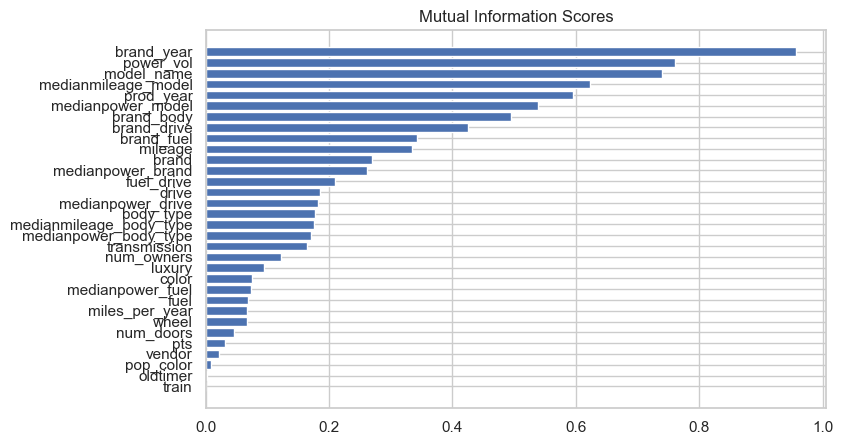

In [677]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [678]:
# show MI scores of 10 most important features
display(mi_scores[:10])

brand_year             0.9575071064639404
power_vol              0.7614784033498312
model_name             0.7393034003665342
medianmileage_model      0.62347741669576
prod_year              0.5959536325807675
medianpower_model      0.5392245335295467
brand_body            0.49528318331221044
brand_drive           0.42517580619907314
brand_fuel             0.3427275438531807
mileage                0.3347390382973101
Name: MI Scores, dtype: float64

As we can see, some newly invented features gained high MI scores: brand_year, power_vol, medianmileage_model, brand_body, etc.

### 5) Clustering

The motivating idea for adding cluster labels is that the clusters will break up complicated relationships across features into simpler chunks. Our model can then just learn the simpler chunks one-by-one instead having to learn the complicated whole all at once. It's a "divide and conquer" strategy.

We will take ten features with highest MI scores to break our data into 30 clusters using **k-means clustering**.

In [679]:
X = df.copy()
y = X.pop('price')

In [680]:
features = mi_scores[:10].index.to_list()

X_cluster = X.loc[:, features]

kmeans = KMeans(n_clusters=30, n_init=20, random_state=29)
X['cluster'] = kmeans.fit_predict(X_cluster)

In [681]:
X['cluster'] = X.cluster.astype('category')
X['price'] = y

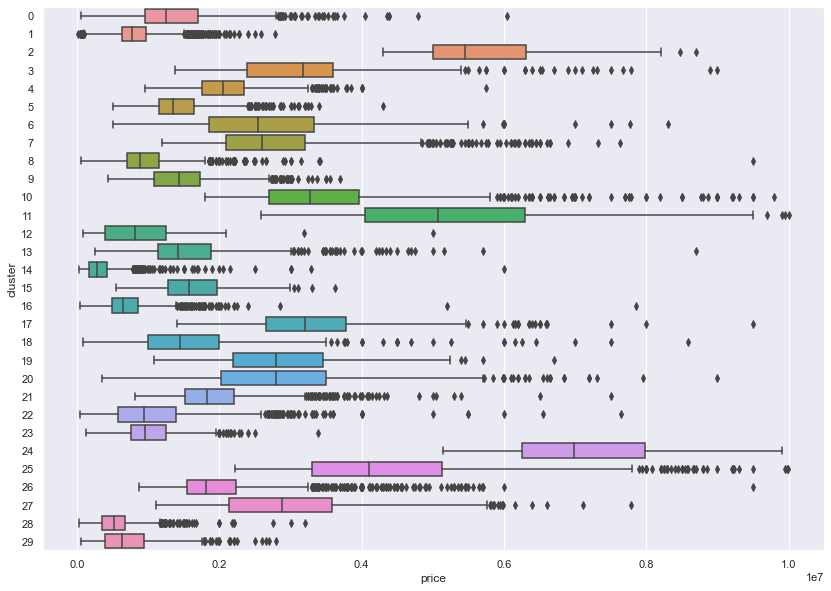

In [682]:
sns.set(rc={'figure.figsize': (14, 10)})
ax = sns.boxplot(x='price', y='cluster', data=X[X.train==1])

There is indeed some variance among our clusters in regard to price!

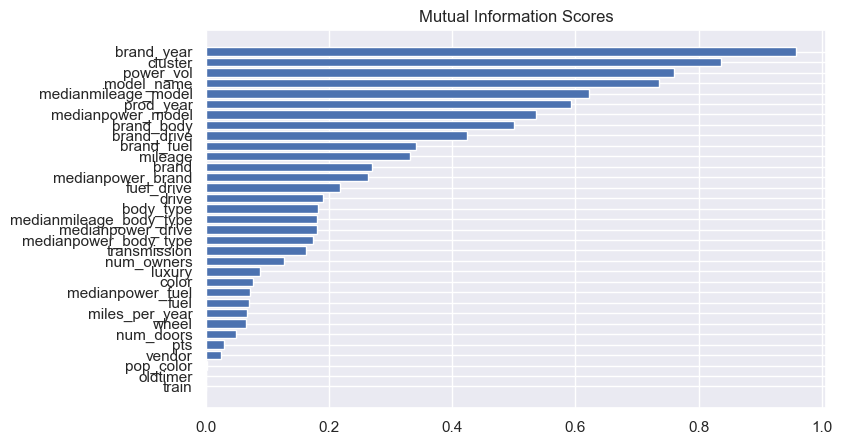

In [683]:
# feature importance

X = X[X.train==1]
y = X.pop('price')

X = X.round(2)

mi_scores = make_mi_scores(X, y)

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [684]:
display(mi_scores[:5])

brand_year            0.9586458458980296
cluster               0.8364463230172063
power_vol             0.7605193736793368
model_name            0.7362812707964146
medianmileage_model   0.6220904924369401
Name: MI Scores, dtype: float64

The new feature 'cluster' seems to be of high importance in predicting our target!

## MODELLING <a name="modelling"></a>

The long and tedious data preparation part is over, and we can finally begin building our predictive model. In this section, we will train and evaluate a few different regressin algorithms. After that, we will pick a model with the lowest **mean absolute percentage error** and tune its hyperparameters. 

First of all, let's check whether our baseline model trained on the transformed data performs better.

In [685]:
train = df[df.train==1].drop('train', 1)
test = df[df.train==0].drop(['train', 'price'], 1)

In [686]:
X, y = train.drop('price', 1), train.loc[:, 'price']

In [687]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=29)

model = CatBoostRegressor(iterations=200, random_state=29)

model.fit(X_train, y_train, cat_features=None, plot=True)
y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.242801
0:	learn: 1097256.7085340	total: 9.57ms	remaining: 1.91s
1:	learn: 904242.0138841	total: 17.5ms	remaining: 1.73s
2:	learn: 768446.9191633	total: 25.4ms	remaining: 1.67s
3:	learn: 672790.5600609	total: 34ms	remaining: 1.67s
4:	learn: 599765.2165917	total: 41.8ms	remaining: 1.63s
5:	learn: 541688.6332467	total: 49.5ms	remaining: 1.6s
6:	learn: 500263.2091468	total: 57.3ms	remaining: 1.58s
7:	learn: 469026.7041142	total: 65.5ms	remaining: 1.57s
8:	learn: 444859.8903111	total: 73.4ms	remaining: 1.56s
9:	learn: 425100.9144689	total: 81.9ms	remaining: 1.56s
10:	learn: 409007.8076490	total: 89.8ms	remaining: 1.54s
11:	learn: 394895.6329281	total: 97.4ms	remaining: 1.53s
12:	learn: 384254.5855409	total: 105ms	remaining: 1.51s
13:	learn: 375541.0247919	total: 112ms	remaining: 1.49s
14:	learn: 368489.8234712	total: 120ms	remaining: 1.48s
15:	learn: 361926.4756874	total: 127ms	remaining: 1.46s
16:	learn: 354695.3207455	total: 135ms	remaining: 1.45s
17:	learn: 349322.

161:	learn: 231026.3033708	total: 1.21s	remaining: 285ms
162:	learn: 230567.7992800	total: 1.22s	remaining: 277ms
163:	learn: 230077.8253627	total: 1.23s	remaining: 270ms
164:	learn: 229823.9698588	total: 1.24s	remaining: 262ms
165:	learn: 229362.3844712	total: 1.24s	remaining: 255ms
166:	learn: 229012.0882425	total: 1.25s	remaining: 247ms
167:	learn: 228449.4882062	total: 1.26s	remaining: 240ms
168:	learn: 228185.3348018	total: 1.26s	remaining: 232ms
169:	learn: 227868.7687872	total: 1.27s	remaining: 225ms
170:	learn: 227741.2368039	total: 1.28s	remaining: 217ms
171:	learn: 227463.4341641	total: 1.29s	remaining: 209ms
172:	learn: 227347.1148198	total: 1.29s	remaining: 202ms
173:	learn: 227010.4790977	total: 1.3s	remaining: 194ms
174:	learn: 226710.9242290	total: 1.31s	remaining: 187ms
175:	learn: 226357.4314174	total: 1.31s	remaining: 179ms
176:	learn: 226075.6526172	total: 1.32s	remaining: 172ms
177:	learn: 225786.7030726	total: 1.33s	remaining: 164ms
178:	learn: 225649.7758955	total

0.15224890288452703

No changes in mean absolute percentage error after feature engineering.

In [688]:
models = []

models.append(('Extra Trees Regressor', ExtraTreesRegressor(random_state=29)))
models.append(('Random Forest Regressor', RandomForestRegressor(random_state=29)))
models.append(('XGBRegressor', XGBRegressor(random_state=29)))
models.append(('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=29)))
models.append(('Ridge Regression', Ridge()))
models.append(('Lasso Regression', Lasso(alpha=0.01, max_iter=100000)))
models.append(('k-neighbors Regressor', KNeighborsRegressor(n_neighbors=3)))

names = []
mape = []
cross_val_scores = []
sigma = []

In [689]:
kfold = KFold(n_splits=5, shuffle=True, random_state=29)
scoring = 'neg_mean_absolute_percentage_error'

for name, model in models:
    mape.append(round(cross_val_score(model, X, y, cv=kfold, scoring=scoring).mean(), 4))
    cross_val_scores.append(cross_val_score(model, X, y, cv=kfold, scoring=scoring))
    sigma.append(np.std(cross_val_score(model, X, y, cv=kfold, scoring=scoring)))
    names.append(name)

In [690]:
fin_scores = pd.DataFrame( { 'models': names, 
                             'MAPE': [-1*x for x in mape],
                             'std': [np.round(x, 4) for x in sigma] } ).sort_values(by='MAPE', ascending=True).set_index('models')
display(fin_scores)

,MAPE,std
models,,
Random Forest Regressor,0.1499,0.0031
Extra Trees Regressor,0.1533,0.0046
XGBRegressor,0.1542,0.004


**Random Forest Regressor** with default hyperparameters has shown the best performance on our training dataset. Linear models with regularization didn't perform well.

Next, we will try to reduce an error of the best model by tuning its hyperparameters.

In [162]:
model = RandomForestRegressor()

param_grid = { 'n_estimators': [300], 
               'max_depth': [10, 15, 20],
               'min_samples_split': [2, 3, 4],
               'min_samples_leaf': [1, 2, 3],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_leaf_nodes': [None, 3, 6, 9] }

grid_search = RandomizedSearchCV(model, 
                                 param_distributions=param_grid, 
                                 cv=kfold,
                                 n_iter=45,
                                 n_jobs=-1,
                                 scoring=scoring,
                                 random_state=29)

In [163]:
grid_search.fit(X, y)
print("Best cross-validation MAPE: {:.4f}".format(-1*(grid_search.best_score_)))
print("Best parameters: ", grid_search.best_params_)

Best cross-validation MAPE: 0.1463
Best parameters:  {'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_leaf_nodes': None, 'max_features': 'auto', 'max_depth': 20}


In [691]:
model = RandomForestRegressor(n_estimators=300, 
                              min_samples_split=3, 
                              min_samples_leaf=3, 
                              max_leaf_nodes=None, 
                              max_features='auto', 
                              max_depth=20,
                              random_state=29)

In [692]:
# for algorithm training, we bring the target to a normal distribution
model.fit(X, np.log(y))

RandomForestRegressor(max_depth=20, min_samples_leaf=3, min_samples_split=3,
                      n_estimators=300, random_state=29)

## SUBMISSION <a name="submission"></a>

In [693]:
prediction = np.rint(np.exp(model.predict(test)) * 0.90)

In [694]:
prediction[:12]

array([ 635951.,  910734.,  797307.,  687392.,  700289.,  690880.,
        617024.,  437232., 2005077.,  660995.,  643161., 1167875.])

In [695]:
submission = pd.read_csv('data/sample_submission.csv')

In [696]:
submission.head()

,sell_id,price
0,1100575026,0
1,1100549428,0
2,1100658222,0
3,1100937408,0
4,1101037972,0


In [697]:
submission['price'] = prediction

In [698]:
submission.to_csv('submission_final.csv', index=False)

In [700]:
pd.read_csv('submission_final.csv').head()

,sell_id,price
0,1100575026,"635,951.0"
1,1100549428,"910,734.0"
2,1100658222,"797,307.0"
3,1100937408,"687,392.0"
4,1101037972,"700,289.0"
